In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import matplotlib
from mantid.simpleapi import *
import matplotlib.patheffects as PathEffects
import matplotlib.patheffects as PathEffects
cwd=os.getcwd()
sys.path.append("../python scripts/")


from nxspetomd import *
from genslices import *
import MDUtils as mdu
from getcolor import *
from cut_mdhisto_powder import *
from mdfactorization import *
from trapzerr import *
from mask_minQ import *
from maskQEbox import *
#Style sheet updates 
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'
plt.close('all')
%matplotlib inline

/home/tom/anaconda3/envs/mantid/lib/python3.6/site-packages/h5py/__init__.py:40: UserWarning: h5py is running against HDF5 1.10.0 when it was built against 1.10.6, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


# This notebook performs the factorization analysis on all three measurements as defined in the main text. It also makes plots of the scattering for the text.

The order is the following :

1. First plot showing SEQUOIA magnetic scattering at 4 K and 100 K with accompanying cuts of raw data
2. Second plot with MACS Data
3. Third plot with MACS, SEQUOIA factorizations
4. Final plot showing polarized scattering results. 

In [2]:
#Load the files correctly, sort into a dictionary.

mds = {}
keys= ['seq_mag','seq_100K','macs_5mag','macs_3p7mag','hys_mag','hys_SF','seq_mag_60meV',\
       'macs_2K_5meV','macs_55K_5meV','macs_2K_3p7meV','macs_55K_3p7meV','hys_SI','hys_NSF']
fdict = {keys[0]:'../MDHisto_files/30_4K_SEQ_mag.nxs',\
        keys[1]:'../MDHisto_files/30_100K_SEQ_mag.nxs',\
        keys[2]:'../MDHisto_files/HLIO_MACS_5p0_mag.nxs',\
        keys[3]:'../MDHisto_files/HLIO_MACS_3p7_mag.nxs',\
        keys[4]:'../MDHisto_files/HLIO_mag_avg.nxspe',\
        keys[5]:'../MDHisto_files/HLIO_tot_SF.nxspe',\
        keys[6]:'../MDHisto_files/60_4K_SEQ_mag.nxs',\
        keys[7]:'../MDHisto_files/macs_5p0_2K.nxs',\
        keys[8]:'../MDHisto_files/macs_5p0_55K.nxs',\
        keys[9]:'../MDHisto_files/macs_3p7_2K.nxs',\
        keys[10]:'../MDHisto_files/macs_3p7_55K.nxs',\
        keys[11]:'../MDHisto_files/HLIO_SI.nxspe',\
        keys[12]:'../MDHisto_files/HLIO_tot_NSF.nxspe'}

qslice_mag = GenQslice(0,3,15)
eslice_mag = GenEslice(0,20,10)
qslice_hys = GenQslice(0,3,60)
eslice_hys = GenEslice(0,20,60)
Qslices={keys[4]:qslice_mag,keys[5]:qslice_hys,keys[11]:qslice_hys,keys[12]:qslice_hys}
Eslices={keys[4]:eslice_mag,keys[5]:eslice_hys,keys[11]:eslice_hys,keys[12]:eslice_hys}
for key in keys:
    if 'nxspe' not in fdict[key]:
        ws = LoadMD(fdict[key])
        #For SEQ measurements, mask low angles.
        if 'SEQ' in fdict[key]:
            fname = fdict[key]
            Ei = float(fname.split('/')[-1].split('_')[0])
            ws = mask_minQ_fixedEi_MD(ws,twoThetaMin=4.5,Ei=Ei)
        if 'macs' in fdict[key]:
            fname = fdict[key]
            Ef = float(fname.split('/')[-1].split('_')[1].replace('p','.'))
            ws = mask_minQ_fixedEf_MD(ws,twoThetaMin=12.0,Ef=Ef)
        outws=CloneWorkspace(ws,OutputWorkspace=key)
        mds[key]=outws
    else:
        #HYS data needs to be binned. 
        md = NxspeToMDHisto(fdict[key],Qslices[key],Eslices[key],numEvNorm=False)
        hysscale=2.0e5#1.2e5
        md*=hysscale
        outws=CloneWorkspace(md,OutputWorkspace=key)
        mds[key]=outws        

constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.


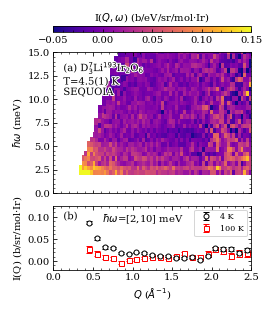

In [3]:
#Begin with a figure showing the SEQUOIA scattering and accompanying cuts

fig=plt.figure(constrained_layout=True,figsize=(3.54,4))

gs = matplotlib.gridspec.GridSpec(3,1,figure=fig)
ax_slice = fig.add_subplot(gs[0:2],projection='mantid')
ax_qcut = fig.add_subplot(gs[2])
#perform the appropriate masking of the elastic line.

ws_masked_60= mask_QE_box_MD(mtd['seq_mag_60meV'],[0,5],[0,3])
ws_masked_60 = CloneWorkspace(ws_masked_60,OutputWorkspace='seq_mag_60meV_plot')
ws_masked_60 = SmoothMD(ws_masked_60,'Hat',WidthVector=1)

ws_masked= mask_QE_box_MD(mtd['seq_mag'],[0,5],[0,1.8])
ws_masked = CloneWorkspace(ws_masked,OutputWorkspace='seq_mag_plot')
ws_masked = SmoothMD(ws_masked,'Hat',WidthVector=1)

cmap='plasma'
vmin=-0.05
vmax=0.15
mesh=ax_slice.pcolormesh(ws_masked_60,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True,zorder=1)

mesh=ax_slice.pcolormesh(ws_masked,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True,zorder=2)
ax_slice.set_ylim(0,15)
ax_slice.set_xlabel('')
ax_slice.set_ylabel('$\hbar\omega$ (meV)')
ax_slice.set_xticklabels([])

txta = ax_slice.text(0.05,0.95,'(a) D$_3^7$Li$^{193}$Ir$_2$O$_6$\nT=4.5(1) K\nSEQUOIA',transform=ax_slice.transAxes,\
                    horizontalalignment='left',verticalalignment='top')
txta.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Add a colorbar
l,b,w,h=ax_slice.get_position().bounds
cax = fig.add_axes([l,b+h+0.07,w,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/mol$\cdot$Ir)'
cbar = plt.colorbar(mesh,orientation='horizontal',cax=cax)
cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',verticalalignment='bottom')
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))

#Plot cuts of both the 100 K and 4 K magnetic scattering. 
qbins=[0,3,0.1]
ebins=[2,10]
q4,i4,err4 = cut_MDHisto_powder(mtd['seq_mag'],'|Q|',qbins,ebins)
q100,i100,err100=cut_MDHisto_powder(mtd['seq_100K'],'|Q|',qbins,ebins)
ax_qcut.errorbar(q4,i4,err4,color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=3,label='4 K',\
                zorder=10)
ax_qcut.errorbar(q100,i100,err100,color='r',marker='s',mfc='w',mec='r',ls=' ',capsize=3,\
                 zorder=5,label='100 K')
ax_qcut.legend(fontsize=8,loc=1,ncol=1)

txtb = ax_qcut.text(0.05,0.90,'(b)',transform=ax_qcut.transAxes,\
                    horizontalalignment='left',verticalalignment='top',)
txtb.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

txtb2 = ax_qcut.text(0.45,0.90, '$\hbar\omega$=[2,10] meV',transform=ax_qcut.transAxes,horizontalalignment='center',\
                    verticalalignment='top')

#Make x limits consistent
ax_slice.set_xlim(0,2.5)
ax_qcut.set_xlim(0,2.5)
ax_qcut.set_ylim(-0.02,0.125)

ax_qcut.set_xlabel('$Q$ ($\AA^{-1}$)')
ax_qcut.set_ylabel('I(Q) (b/sr/mol$\cdot$Ir)')

fig.savefig('DLIO_SEQ_scattering.pdf',bbox_inches='tight',dpi=400)

## The factorization of the above scattering is handled in the script mdfactorization.py

Be wary that the calculation of uncertainties takes a significant amount of time (~10 min on test desktop). To skip that calculation, set fast_mode=True for a 30% error bar. Feel free to load the pre-calculated factorization.

The plot for the factorization will be 

fit A0.026021178534940015
fit B2.541578087942883
fit C1.0518675503647659


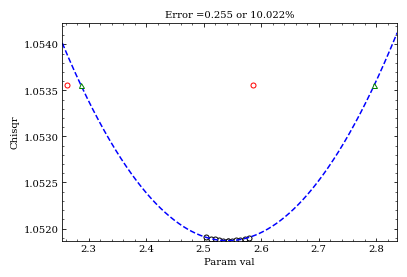

[                                        ]  1/63 (  1%) 62 to go

fit A0.028516704625176317
fit B2.720393866096023
fit C1.0518675468706904


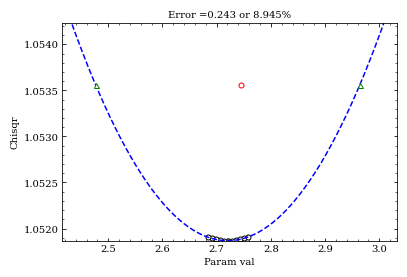

[=                                       ]  2/63 (  3%) 61 to go

fit A0.029694454485511723
fit B2.67983321779848
fit C1.0518675474789367


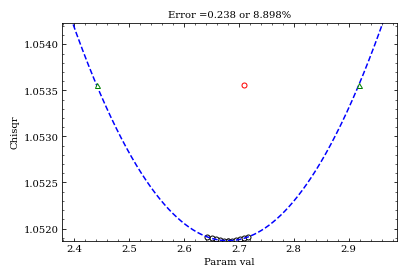

[=                                       ]  3/63 (  4%) 60 to go

fit A0.029314474690671267
fit B2.2181433808962385
fit C1.0518675437368292


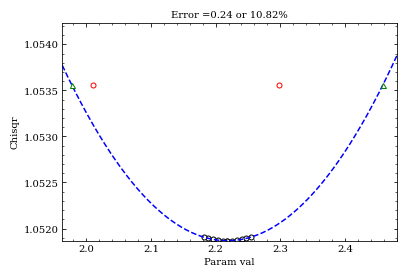

[==                                      ]  4/63 (  6%) 59 to go

fit A0.02605536068251633
fit B2.2757295744156805
fit C1.0518675426573019


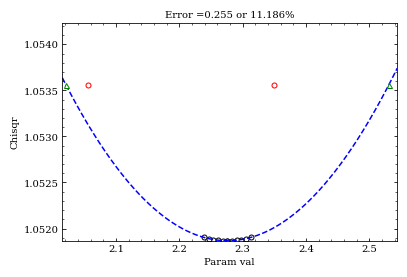

[===                                     ]  5/63 (  7%) 58 to go

fit A0.02872731417661474
fit B1.9603804994897467
fit C1.0518675427014141


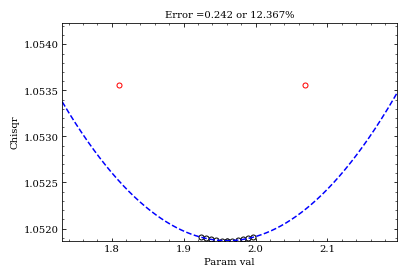

[===                                     ]  6/63 (  9%) 57 to go

fit A0.03504773369585935
fit B1.69851909325516
fit C1.0518675425934216


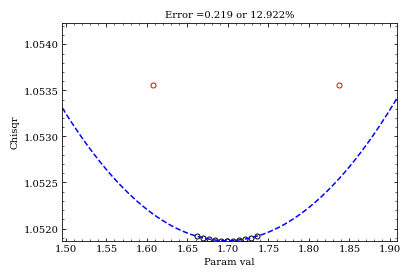

[====                                    ]  7/63 ( 11%) 56 to go

fit A0.04166432555561772
fit B1.4668999128312656
fit C1.05186754264583


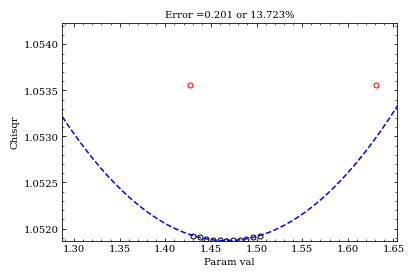

[=====                                   ]  8/63 ( 12%) 55 to go

fit A0.046614536095646836
fit B1.6195396947085505
fit C1.0518675425907726


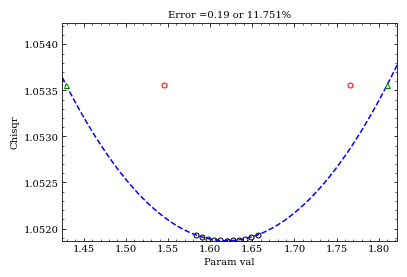

[=====                                   ]  9/63 ( 14%) 54 to go

fit A0.06394409543071934
fit B1.2913549884516562
fit C1.051867542728227


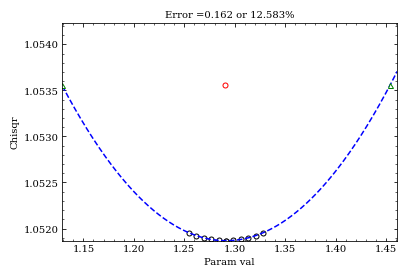

[======                                  ] 10/63 ( 15%) 53 to go

fit A0.062146367656872405
fit B1.4416825218822782
fit C1.0518675425850483


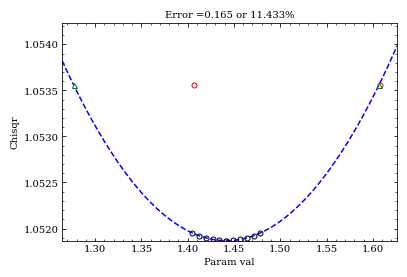

[======                                  ] 11/63 ( 17%) 52 to go

fit A0.06656140476678116
fit B1.2506754257263997
fit C1.0518675427665543


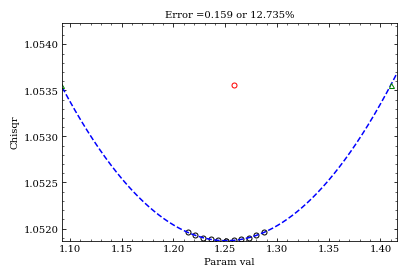

[=======                                 ] 12/63 ( 19%) 51 to go

fit A0.05913747245579743
fit B1.683918200661625
fit C1.0518675426574922


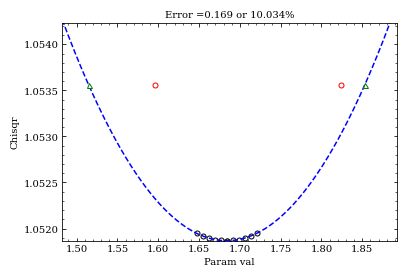

[========                                ] 13/63 ( 20%) 50 to go

fit A0.07349577573054153
fit B0.9116088528094135
fit C1.0518675428493556


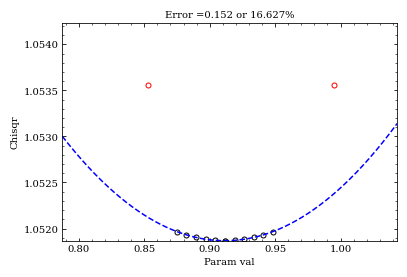

[========                                ] 14/63 ( 22%) 49 to go

fit A0.07356214070053706
fit B1.1523464878022356
fit C1.0518675434661369


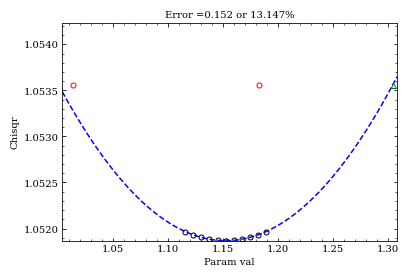

[=========                               ] 15/63 ( 23%) 48 to go

fit A0.10035671116925146
fit B0.8731417928954829
fit C1.0518675427696498


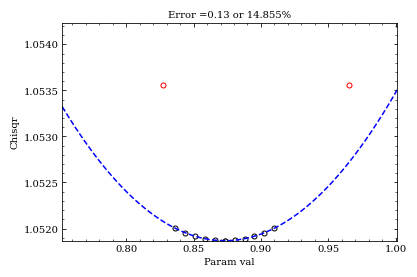

[==========                              ] 16/63 ( 25%) 47 to go

fit A0.0910479321860046
fit B1.0361514708134136
fit C1.0518675426269097


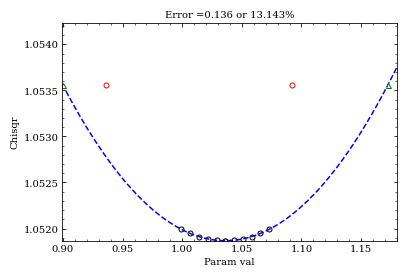

[==========                              ] 17/63 ( 26%) 46 to go

fit A0.09319511818099283
fit B0.7443160613952077
fit C1.0518675433896256


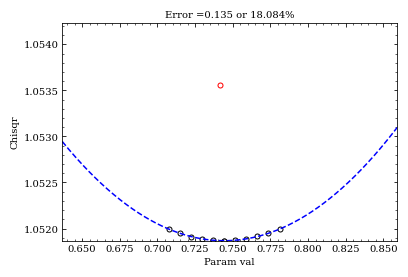

[===========                             ] 18/63 ( 28%) 45 to go

fit A0.09255284863999222
fit B0.8361148137294537
fit C1.0518675442498564


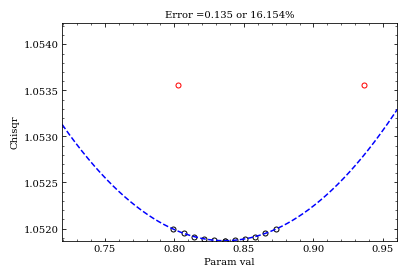

[============                            ] 19/63 ( 30%) 44 to go

fit A0.0944000534053329
fit B0.8742170342779103
fit C1.0518675426270596


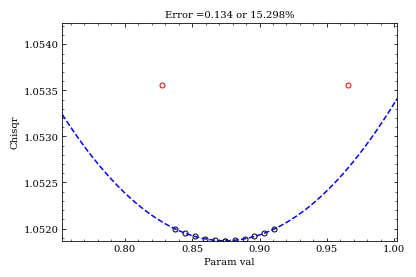

[============                            ] 20/63 ( 31%) 43 to go

fit A0.09064034560327106
fit B1.1035818971474634
fit C1.0518675430779276


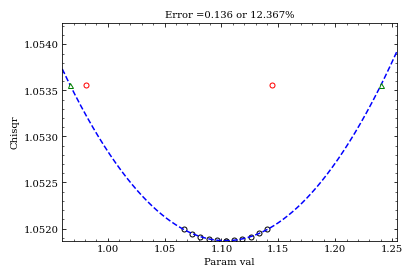

[=============                           ] 21/63 ( 33%) 42 to go

fit A0.13053816298527163
fit B0.8112977765490185
fit C1.0518675444806138


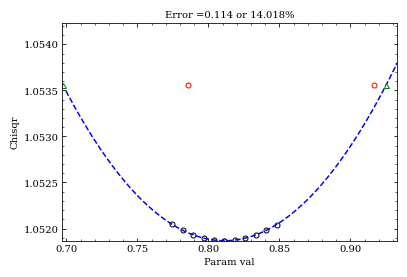

[=============                           ] 22/63 ( 34%) 41 to go

fit A0.09552684334740623
fit B1.0612492944229832
fit C1.051867543481935


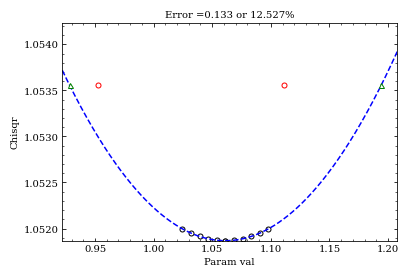

[==============                          ] 23/63 ( 36%) 40 to go

fit A0.09653250381598685
fit B1.0003951938770723
fit C1.0518675426251525


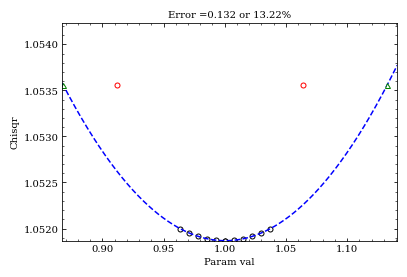

[===============                         ] 24/63 ( 38%) 39 to go

fit A0.09716060877404721
fit B0.7721801838486114
fit C1.0518675425896729


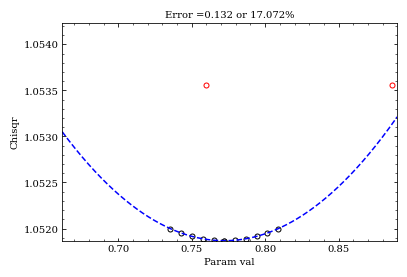

[===============                         ] 25/63 ( 39%) 38 to go

fit A0.08801664442075621
fit B1.0087619507638643
fit C1.0518675435138414


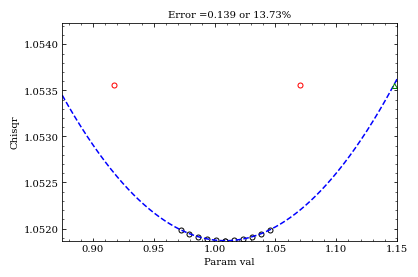

[================                        ] 26/63 ( 41%) 37 to go

fit A0.09255095825903419
fit B0.7357934286360961
fit C1.0518675438199678


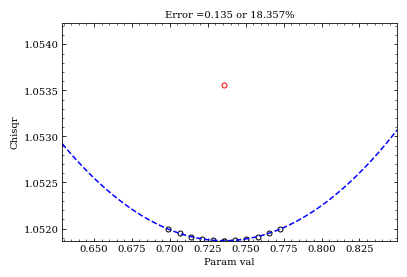

[=================                       ] 27/63 ( 42%) 36 to go

fit A0.09280957347907522
fit B0.8790870092829173
fit C1.0518675441097838


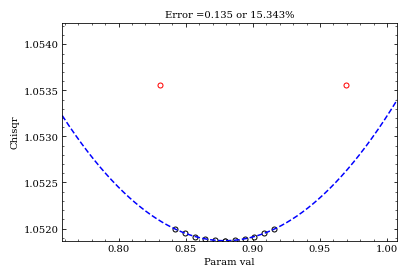

[=================                       ] 28/63 ( 44%) 35 to go

fit A0.07687618227312688
fit B0.6649574887323509
fit C1.051867542989542


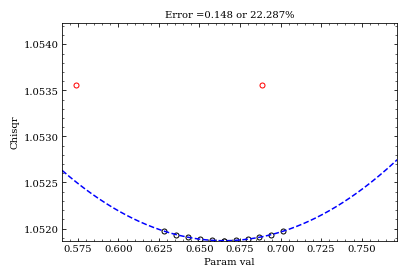

[==================                      ] 29/63 ( 46%) 34 to go

fit A0.07589571064133298
fit B0.7723609251904235
fit C1.0518675461382114


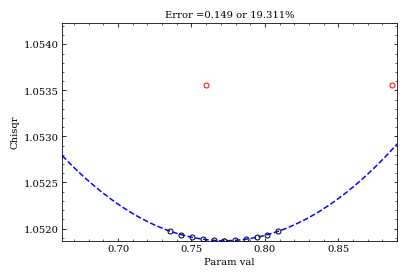

[===================                     ] 30/63 ( 47%) 33 to go

fit A0.07552331872199522
fit B0.7610396643980047
fit C1.0518675456634718


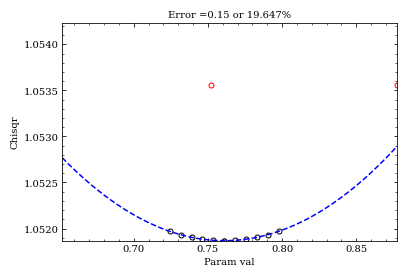

[===================                     ] 31/63 ( 49%) 32 to go

fit A0.08977792304081814
fit B0.7479370251105011
fit C1.0518675433575544


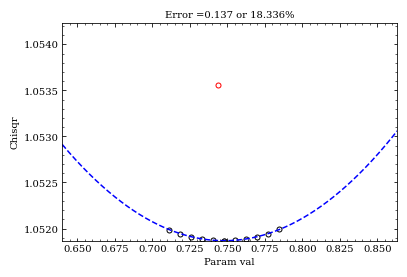

[====================                    ] 32/63 ( 50%) 31 to go

fit A0.08339619528061885
fit B0.7410331114315748
fit C1.0518675429148265


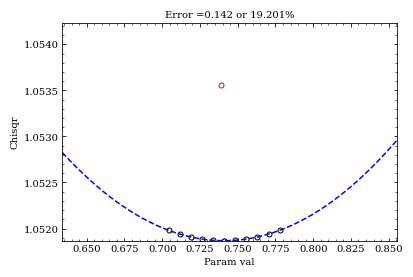

[====================                    ] 33/63 ( 52%) 30 to go

fit A0.08120761502845968
fit B0.8320950878413432
fit C1.051867545943227


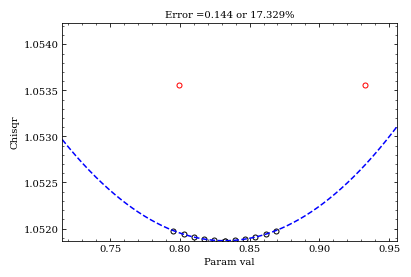

[=====================                   ] 34/63 ( 53%) 29 to go

fit A0.07057887129557912
fit B0.5022375963857005
fit C1.051867543188014


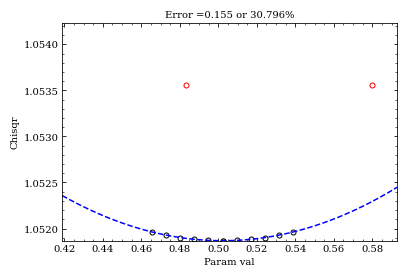

[======================                  ] 35/63 ( 55%) 28 to go

fit A0.0725258670421632
fit B0.5177636245809599
fit C1.0518675447988293


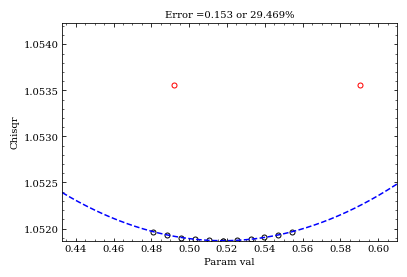

[======================                  ] 36/63 ( 57%) 27 to go

fit A0.06728221574539663
fit B0.536250169860397
fit C1.0518675427731543


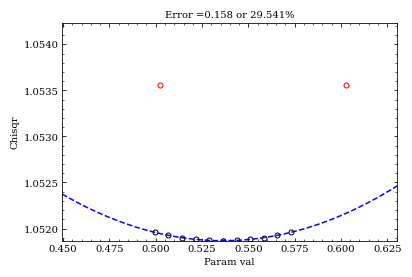

[=======================                 ] 37/63 ( 58%) 26 to go

fit A0.07164549306686473
fit B0.5019527262443542
fit C1.0518675431521414


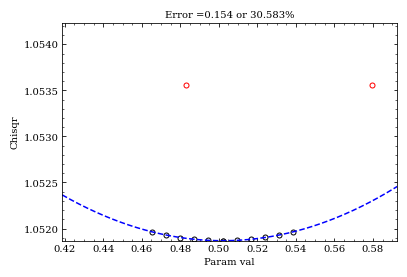

[========================                ] 38/63 ( 60%) 25 to go

fit A0.0670278514283053
fit B0.4890476023049372
fit C1.0518675455018236


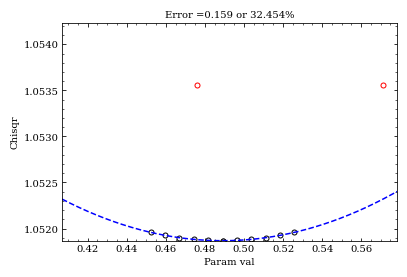

[========================                ] 39/63 ( 61%) 24 to go

fit A0.06682838964343167
fit B0.5688356695518859
fit C1.0518675427883684


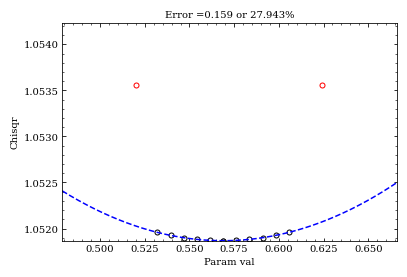

[=========================               ] 40/63 ( 63%) 23 to go

fit A0.05873781194195901
fit B0.6270388527801241
fit C1.0518675426277644


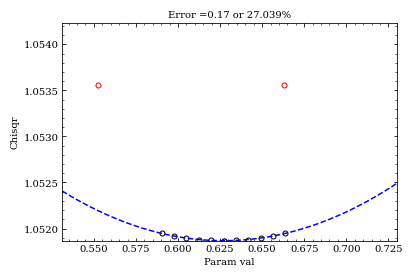

[==========================              ] 41/63 ( 65%) 22 to go

fit A0.05694971309554041
fit B0.5265362544720575
fit C1.0518675434128497


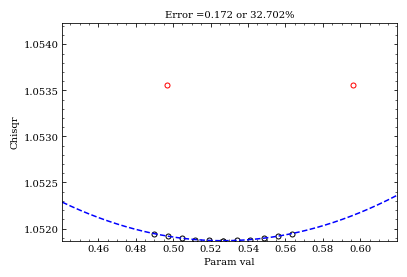

[==========================              ] 42/63 ( 66%) 21 to go

fit A0.05822301485306668
fit B0.3450122207717575
fit C1.051867544561294


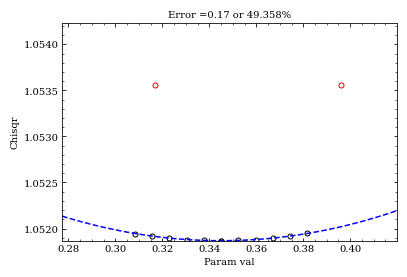

[===========================             ] 43/63 ( 68%) 20 to go

fit A0.05565778324619473
fit B0.12665914136726786
fit C1.0518675429762334


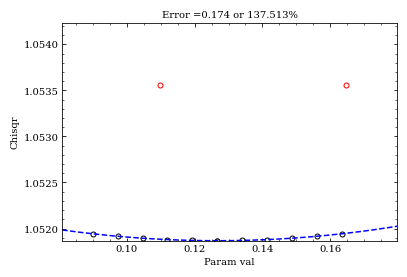

[===========================             ] 44/63 ( 69%) 19 to go

fit A0.05126729569070351
fit B0.6389681143017458
fit C1.0518675429564912


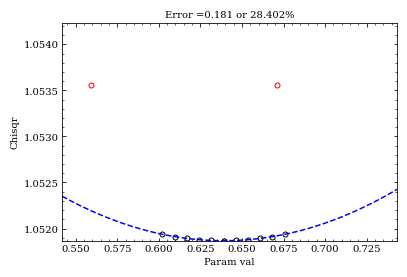

[============================            ] 45/63 ( 71%) 18 to go

fit A0.03647922204572081
fit B0.54890757706758
fit C1.051867544539586


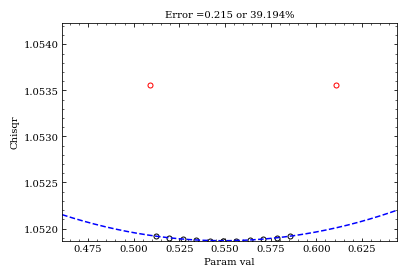

[=============================           ] 46/63 ( 73%) 17 to go

fit A0.03474190115886332
fit B0.7403742655071482
fit C1.0518675444606045


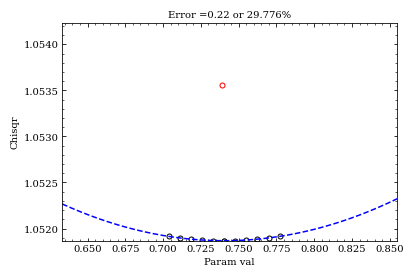

[=============================           ] 47/63 ( 74%) 16 to go

fit A0.011210714197233004
fit B0.054418224957829886
fit C1.0518675427278745


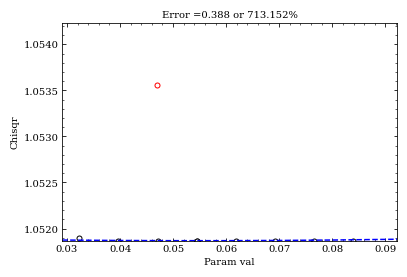

[==============================          ] 48/63 ( 76%) 15 to go

fit A177.18383257386853
fit B0.054181985317452774
fit C1.0518675440284873


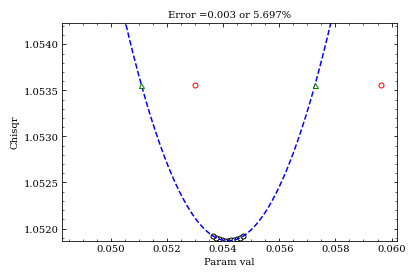

[===============================         ] 49/63 ( 77%) 14 to go

fit A350.6481444876005
fit B0.02628821911861645
fit C1.0518675425866466


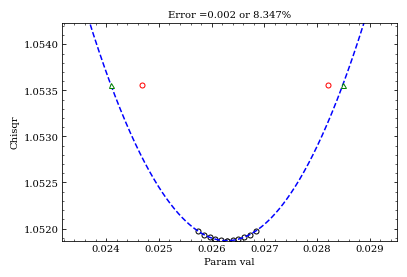

[===============================         ] 50/63 ( 79%) 13 to go

fit A314.60412524245993
fit B0.02995395472011353
fit C1.0518675427073019


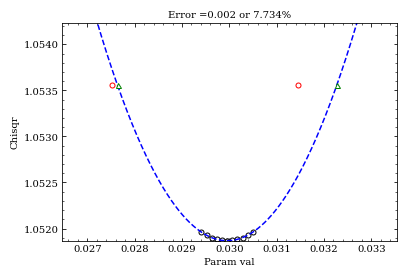

[================================        ] 51/63 ( 80%) 12 to go

fit A312.9741093083243
fit B0.02333988174283408
fit C1.0518675429031603


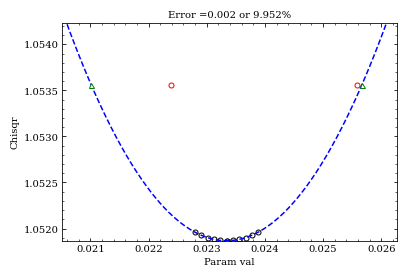

[=================================       ] 52/63 ( 82%) 11 to go

fit A291.6530781701844
fit B0.024293907940135195
fit C1.0518675430403939


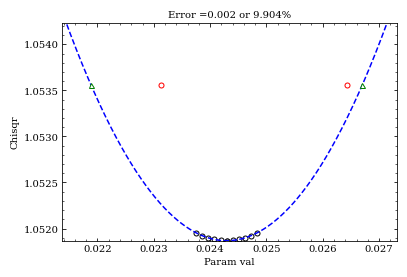

[=================================       ] 53/63 ( 84%) 10 to go

fit A300.6283382918262
fit B0.016892940796575218
fit C1.0518675428778377


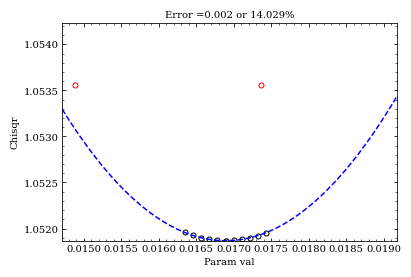

[==================================      ] 54/63 ( 85%)  9 to go

fit A306.4170406151842
fit B0.005892441037352203
fit C1.051867542614195


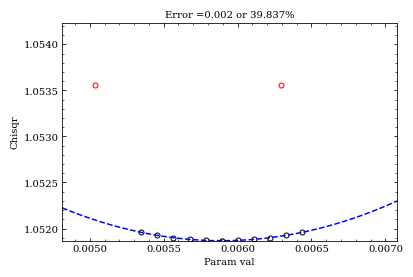

[==================================      ] 55/63 ( 87%)  8 to go

fit A5282.453519928179
fit B0.0
fit C1.0516644414458887


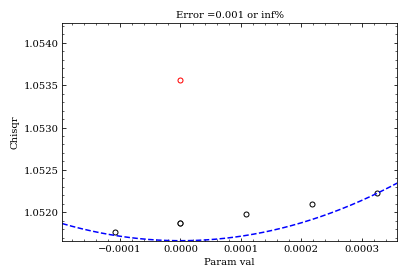

[===================================     ] 56/63 ( 88%)  7 to go

fit A256.27845085672067
fit B0.0006883630481713254
fit C1.0518675427313346


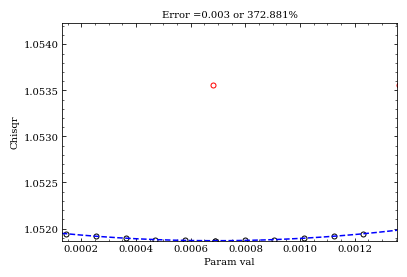

[====================================    ] 57/63 ( 90%)  6 to go

fit A233.8410221653768
fit B0.009473311255095318
fit C1.0518675427196336


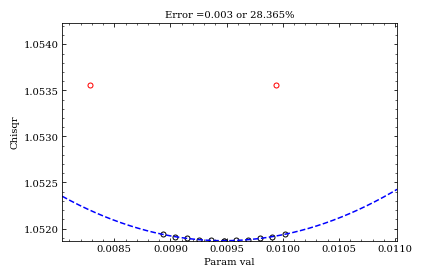

[====================================    ] 58/63 ( 92%)  5 to go

fit A223.54571954249337
fit B0.008212364777681946
fit C1.0518675427096575


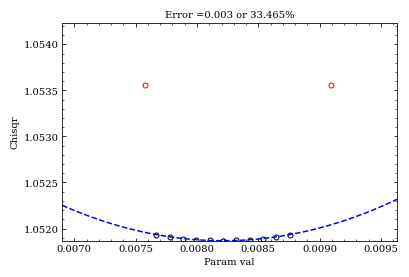

[=====================================   ] 59/63 ( 93%)  4 to go

fit A205.51194029935465
fit B0.014408592770187134
fit C1.0518675431392615


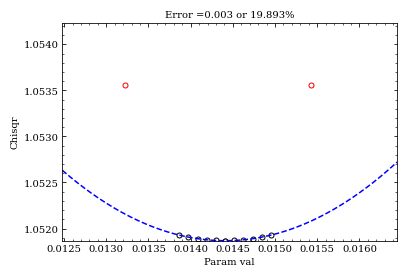

[======================================  ] 60/63 ( 95%)  3 to go

fit A206.70995645377226
fit B0.0051284506624034165
fit C1.051867542691382


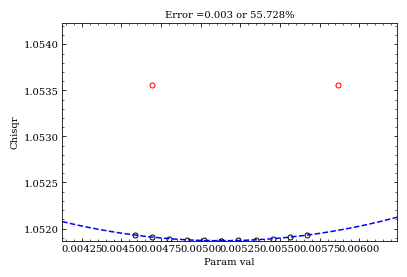

[======================================  ] 61/63 ( 96%)  2 to go

fit A192.17778845099357
fit B0.007870699566379091
fit C1.0518675425915438


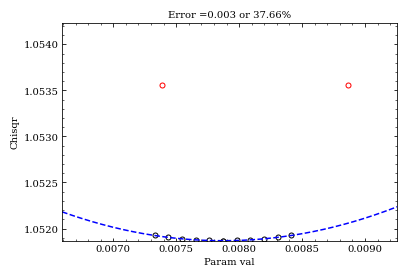

[======================================= ] 62/63 ( 98%)  1 to go

fit A182.54265841834604
fit B0.0086708280309431
fit C1.0518675426484916


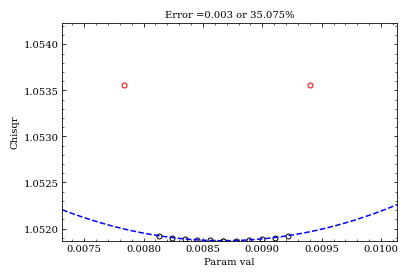

[========================================] 63/63 (100%)  0 to go

In [4]:
seq_factor_fname='SEQ_fact.npy'
qseq,sqseq,sqerrseq,eseq,geseq,geerrseq=MDfactorization(mtd['seq_mag'],mag_ion='Ir4',\
                                     q_lim=[0.35,2.0],e_lim=[2,10.0],Ei=60.0,\
                                     twoThetaMin=4.0,plot_result=False,method='powell',fname=seq_factor_fname,\
                                     overwrite_prev= ,allow_neg_E=False,g_factor=2.0,fast_mode=False)

Mu_eff from factorization=1.77(0.321) muB


<ErrorbarContainer object of 3 artists>

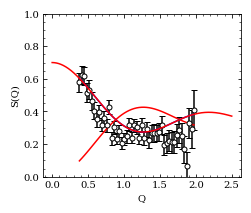

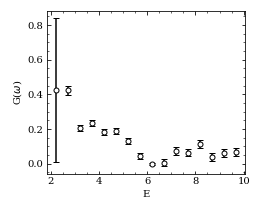

In [5]:
#Quick plot offactorization below.
norm_err = 0.3
frac_err = norm_err#*sqseq/sqerrseq
#Also check the measured moment. 
mu_eff = np.sqrt(3.0*(2.0**2)*np.trapz(sqseq*(qseq**2),x=qseq)/np.trapz(qseq**2,x=qseq))
muerrsqr = 3.0*(2.0**2)*get_trapz_err(qseq,sqseq*(qseq**2),\
                                      sqseq*np.sqrt((sqerrseq/sqerrseq)**2+frac_err**2) *(qseq**2))/np.trapz(qseq**2,x=qseq)
muerr = mu_eff*(muerrsqr/mu_eff**2 )
print(f"Mu_eff from factorization={mu_eff:.2f}({muerr:.3f}) muB")
def modelq(q,A):
    return A*(1.0-np.sin(q*3.54)/(q*3.54))

def modelq2(q,A):
    return A*(1.0+np.sin(q*3.54)/(q*3.54))

plt.figure(figsize=(3.54,3))
plt.errorbar(qseq,sqseq,sqerrseq,marker='o',mfc='w',mec='k',ls=' ',color='k',capsize=3)
plt.plot(qseq,modelq(qseq,0.35),'r-')
plt.plot(qseq,modelq2(qseq,0.35),'b-')
def modelq(q,A):
    return A*(1.0+np.sin(q*3.54)/(q*3.54))
qmodel = np.linspace(0,2.5,1000)
ffmodel=1.0/get_MANTID_magFF(qmodel,'Ir4')[1]
seq_scale=1.0
plt.plot(qmodel,modelq(qmodel,0.35)*seq_scale,'r-',zorder=100)

plt.ylim(0,1)
plt.xlabel('Q')
plt.ylabel('S(Q)')
plt.figure(figsize=(3.54,3))
plt.xlabel('E')
plt.ylabel('G($\omega$)')
geerrseq[np.argwhere(geerrseq>3.0*np.nanmean(geerrseq))]=2.0*np.nanmean(geerrseq)
plt.errorbar(eseq,geseq,geerrseq,marker='o',mfc='w',mec='k',ls=' ',color='k',capsize=3)
#plt.ylim(0,0.5)

## Plot of both MACS measurements here

constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.


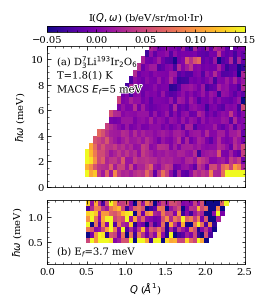

In [6]:
fig=plt.figure(constrained_layout=True,figsize=(3.54,4))

gs = matplotlib.gridspec.GridSpec(3,2,figure=fig)

#Perform masking of low-Q and elastic lines
ws_macs_masked= mask_QE_box_MD(mtd['macs_5mag'],[0,5],[0,1.0])
ws_macs_masked= mask_QE_box_MD(ws_macs_masked,[0,0.5],[0,20.0])
ws_macs_masked = CloneWorkspace(ws_macs_masked,OutputWorkspace='macs_5mag_plot')
#ws_macs_masked = SmoothMD(ws_macs_masked,'Hat',WidthVector=3)

ws_macs3_masked= mask_QE_box_MD(mtd['macs_3p7mag'],[0,5],[0,0.3])
ws_macs3_masked= mask_QE_box_MD(ws_macs3_masked,[0,0.5],[0,2.0])
ws_macs3_masked= mask_QE_box_MD(ws_macs3_masked,[0,2.5],[0,0.5])

ws_macs3_masked = CloneWorkspace(ws_macs3_masked,OutputWorkspace='macs_3p7mag_plot')
ws_macs3_masked = SmoothMD(ws_macs3_masked,'Hat',WidthVector=1)
ax_5 = fig.add_subplot(gs[0:2,:],projection='mantid')
ax_5.pcolormesh(ws_macs_masked,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
ax_5.set_xlabel('')
ax_5.set_xticklabels([])
ax_5.set_ylabel('$\hbar\omega$ (meV)')
ax_5.set_ylim(0,11)
labela = ax_5.text(0.05,0.95,'(a) D$_3^7$Li$^{193}$Ir$_2$O$_6$\nT=1.8(1) K\nMACS $E_f$=5 meV',transform=ax_5.transAxes,verticalalignment='top',horizontalalignment='left')
labela.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Add a colorbar
l,b,w,h=ax_5.get_position().bounds
cax = fig.add_axes([l,b+h+0.05,w,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/mol$\cdot$Ir)'
cbar = plt.colorbar(mesh,orientation='horizontal',cax=cax)
cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',verticalalignment='bottom')
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))

ax_3 = fig.add_subplot(gs[2,:],projection='mantid')
ax_3.pcolormesh(ws_macs3_masked,vmin=vmin,vmax=vmax,cmap=cmap,rasterized=True)
ax_3.set_xlabel('$Q$ ($\AA^{1}$)')
ax_3.set_ylabel('$\hbar\omega$ (meV)')
txt3=ax_3.text(0.05,0.08,'(b) E$_f$=3.7 meV',transform=ax_3.transAxes,verticalalignment='bottom',horizontalalignment='left')
txt3.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Make consistent Q dimensions between the different Ef's
qlim=[0,2.5]
ax_5.set_xlim(qlim[0],qlim[1])
ax_3.set_xlim(qlim[0],qlim[1])


fig.savefig('DLIO_MACS_scattering.pdf',bbox_inches='tight',dpi=300)

## Factorization of MACS data here

fit A0.0032541977067640877
fit B5.17521689293501
fit C0.5360349598319233


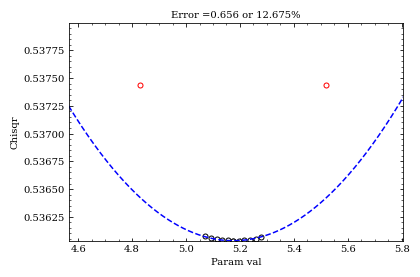

[                                        ]  1/48 (  2%) 47 to go

fit A0.007565722221519275
fit B3.6693993105441143
fit C0.5360349416674861


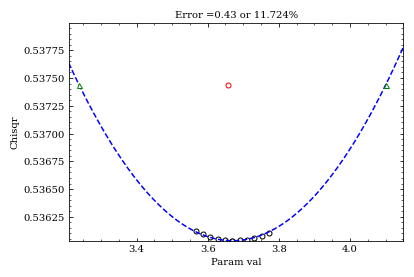

[=                                       ]  2/48 (  4%) 46 to go

fit A0.011746822504310687
fit B2.716998482130609
fit C0.5360348565018705


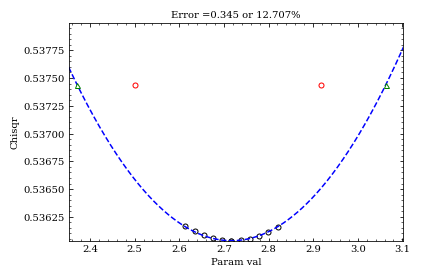

[==                                      ]  3/48 (  6%) 45 to go

fit A0.02141069663244048
fit B1.6159175999787951
fit C0.536034849411209


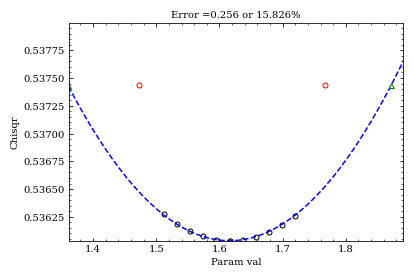

[===                                     ]  4/48 (  8%) 44 to go

fit A0.023095315996845427
fit B1.760465755656933
fit C0.536034818687528


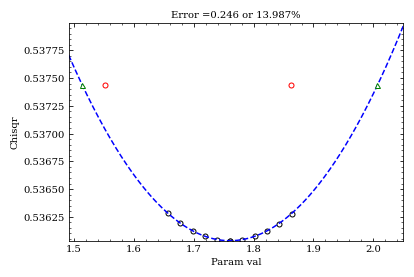

[====                                    ]  5/48 ( 10%) 43 to go

fit A0.030021076879946536
fit B1.383017921376354
fit C0.5360348109006784


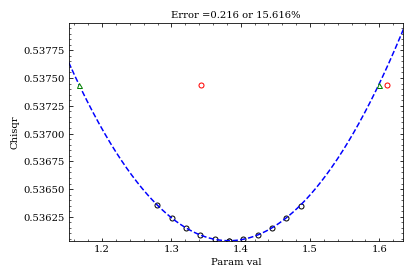

[=====                                   ]  6/48 ( 12%) 42 to go

fit A0.03383755198936556
fit B1.098279497618238
fit C0.5360348132522323


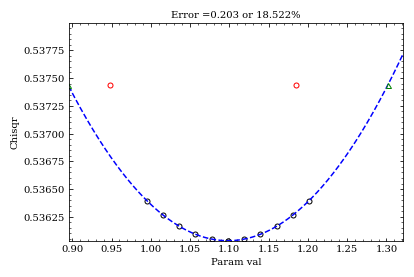

[=====                                   ]  7/48 ( 14%) 41 to go

fit A0.03435421575142121
fit B1.1407762127130021
fit C0.5360348159692385


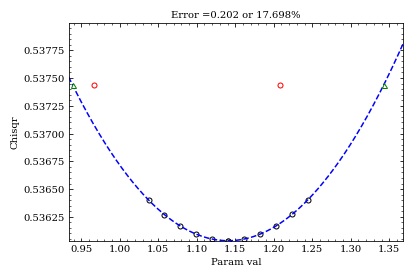

[======                                  ]  8/48 ( 16%) 40 to go

fit A0.04140558872923118
fit B0.9647091039831601
fit C0.5360348261146926


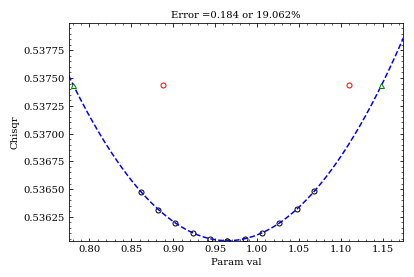

[=======                                 ]  9/48 ( 18%) 39 to go

fit A0.042056350105556466
fit B1.2455502073822278
fit C0.5360348350397303


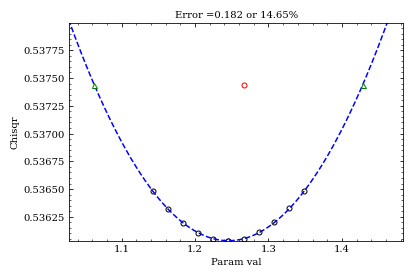

[========                                ] 10/48 ( 20%) 38 to go

fit A0.04417381740498879
fit B0.9396382403542731
fit C0.536034809640538


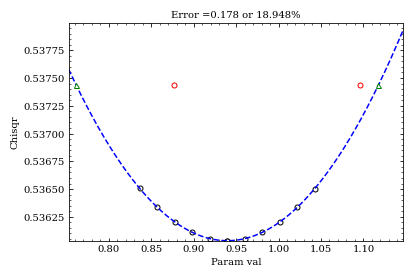

[=========                               ] 11/48 ( 22%) 37 to go

fit A0.04135757462127184
fit B0.79228993702361
fit C0.5360348216254361


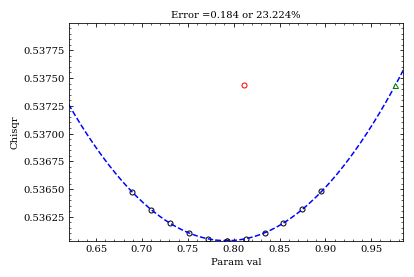

[==========                              ] 12/48 ( 25%) 36 to go

fit A0.042432183538311116
fit B0.9803503013929643
fit C0.5360348096994569


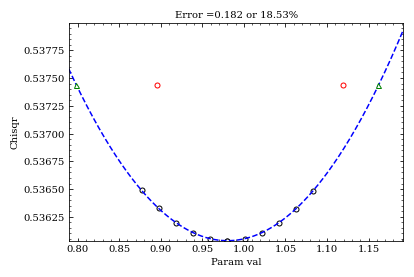

[==========                              ] 13/48 ( 27%) 35 to go

fit A0.046689787333235484
fit B0.7294377322339283
fit C0.5360348207480073


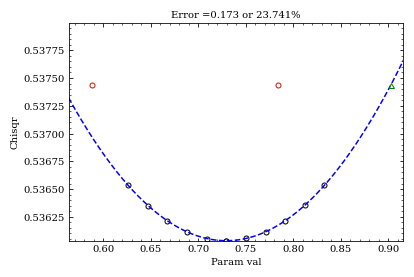

[===========                             ] 14/48 ( 29%) 34 to go

fit A0.04307256854040521
fit B1.114708503896589
fit C0.5360348429000068


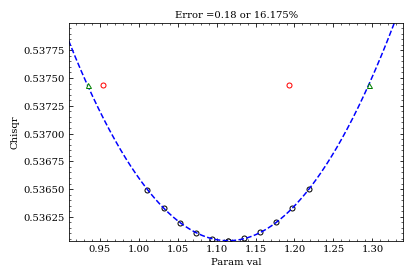

[============                            ] 15/48 ( 31%) 33 to go

fit A0.04444317766154455
fit B1.0412195388245524
fit C0.5360348834030039


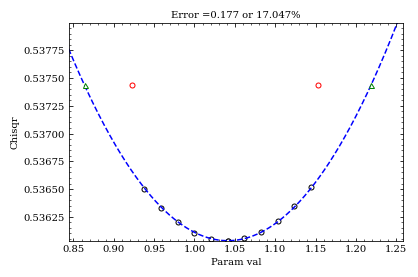

[=============                           ] 16/48 ( 33%) 32 to go

fit A0.03988598602031078
fit B0.7886684057435638
fit C0.5360348856497509


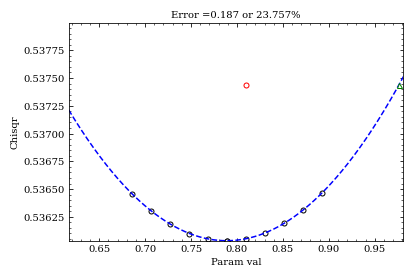

[==============                          ] 17/48 ( 35%) 31 to go

fit A0.04290098238255949
fit B0.474680753026878
fit C0.536034813467698


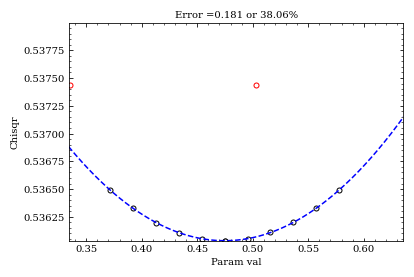

[===============                         ] 18/48 ( 37%) 30 to go

fit A0.03839140309966869
fit B0.5645275709980481
fit C0.5360348219781108


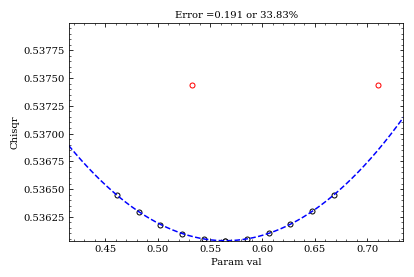

[===============                         ] 19/48 ( 39%) 29 to go

fit A0.03544560623585036
fit B0.8492285385610857
fit C0.5360348416166948


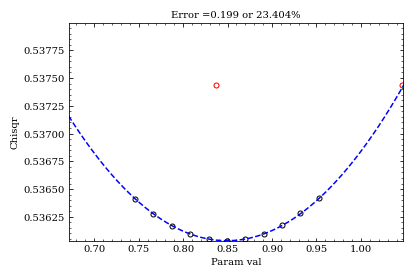

[================                        ] 20/48 ( 41%) 28 to go

fit A0.054862698379864294
fit B0.7726891588952716
fit C0.53603486502497


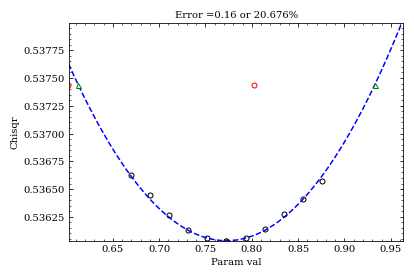

[=================                       ] 21/48 ( 43%) 27 to go

fit A0.028923712296009128
fit B0.33840862346923384
fit C0.5360348422912253


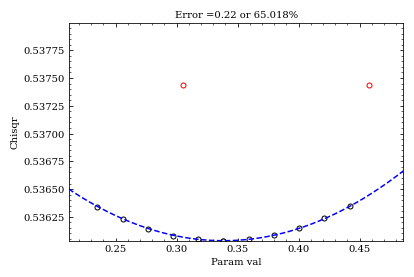

[==================                      ] 22/48 ( 45%) 26 to go

fit A0.02760711572645252
fit B0.4487895497076866
fit C0.5360348104092933


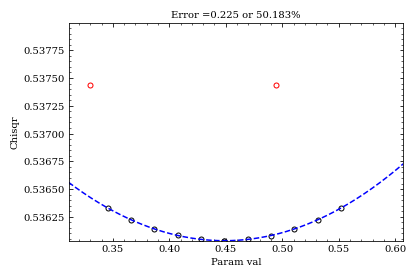

[===================                     ] 23/48 ( 47%) 25 to go

fit A0.02597796686747846
fit B0.5500639053476015
fit C0.5360348087502198


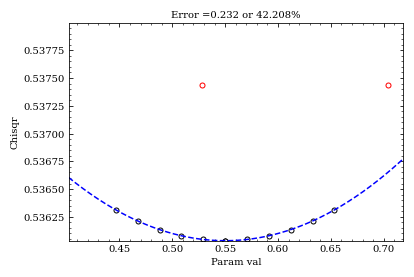

[====================                    ] 24/48 ( 50%) 24 to go

fit A0.025865127937106745
fit B0.4734033798240219
fit C0.5360348085448867


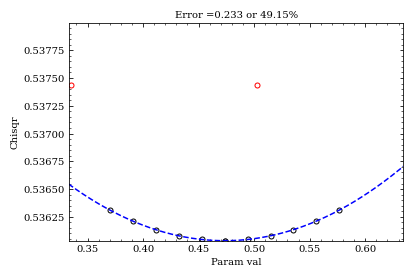

[====================                    ] 25/48 ( 52%) 23 to go

fit A0.02341729023095627
fit B0.5271700144926543
fit C0.5360348083891106


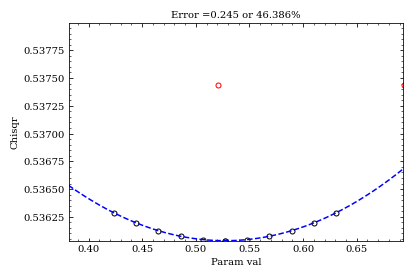

[=====================                   ] 26/48 ( 54%) 22 to go

fit A0.023054123623312474
fit B0.5437276054377105
fit C0.536034809139474


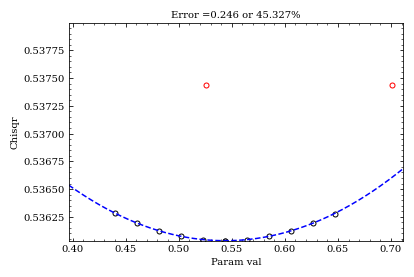

[======================                  ] 27/48 ( 56%) 21 to go

fit A0.021644991839096503
fit B0.518363033999423
fit C0.5360348090020666


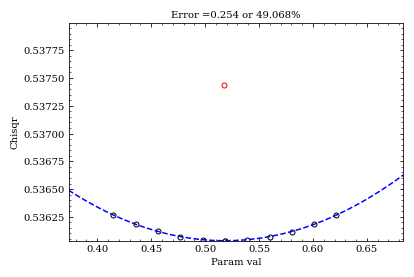

[=======================                 ] 28/48 ( 58%) 20 to go

fit A0.02214572026236575
fit B0.6958799292268469
fit C0.5360348087097739


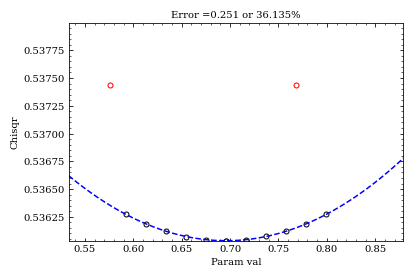

[========================                ] 29/48 ( 60%) 19 to go

fit A0.023382277028963002
fit B0.5915720907543909
fit C0.5360348186418498


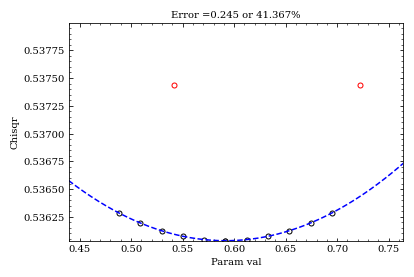

[=========================               ] 30/48 ( 62%) 18 to go

fit A15.197476749967887
fit B0.03649428733073232
fit C0.5360348248458575


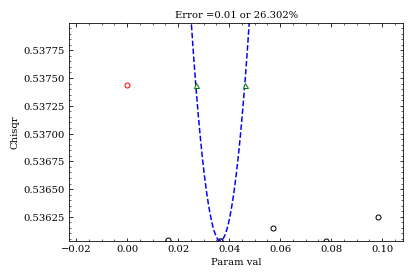

[=========================               ] 31/48 ( 64%) 17 to go

fit A131.88950994153225
fit B0.027370522775116868
fit C0.5360348440426114


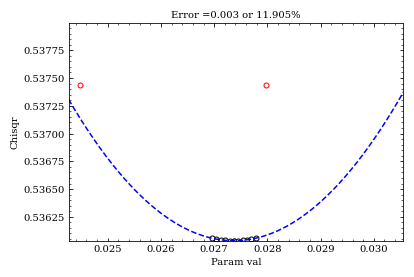

[==========================              ] 32/48 ( 66%) 16 to go

fit A119.23508465922241
fit B0.03481640405001585
fit C0.5360348169222103


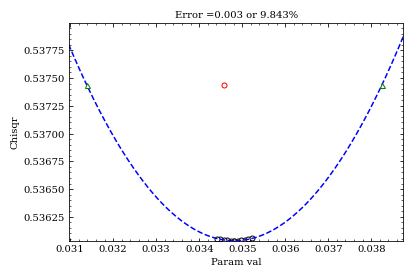

[===========================             ] 33/48 ( 68%) 15 to go

fit A150.66705114006777
fit B0.029510342809938583
fit C0.5360348096835573


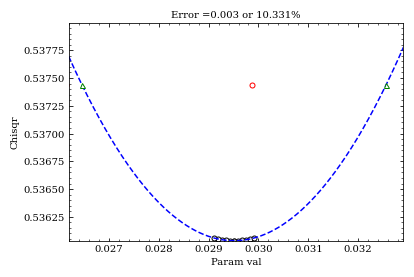

[============================            ] 34/48 ( 70%) 14 to go

fit A145.41113960469937
fit B0.02932324394910113
fit C0.5360348094569606


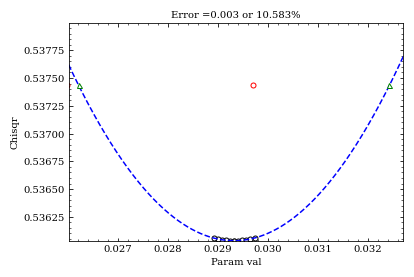

[=============================           ] 35/48 ( 72%) 13 to go

fit A138.87066044236448
fit B0.022458250724888495
fit C0.5360348193889876


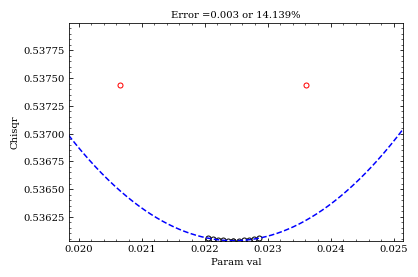

[==============================          ] 36/48 ( 75%) 12 to go

fit A213.25172433528994
fit B0.022960890337736073
fit C0.5360348585916483


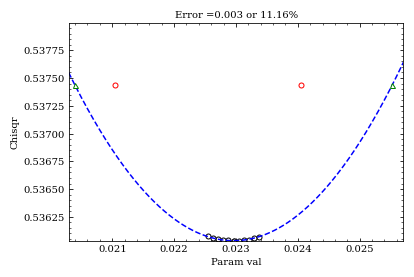

[==============================          ] 37/48 ( 77%) 11 to go

fit A146.46027604370937
fit B0.006917993556828428
fit C0.5360348137734549


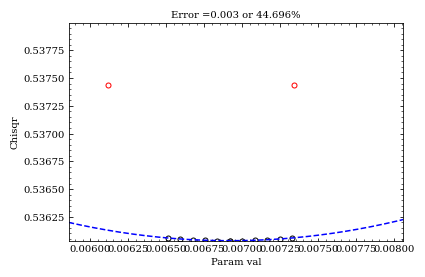

[===============================         ] 38/48 ( 79%) 10 to go

fit A128.3102060707572
fit B0.007883328422545466
fit C0.5360348102614476


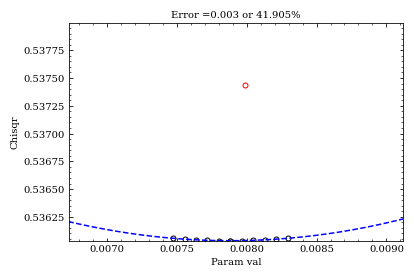

[================================        ] 39/48 ( 81%)  9 to go

fit A120.79856026552258
fit B0.01120277670498826
fit C0.5360348168648961


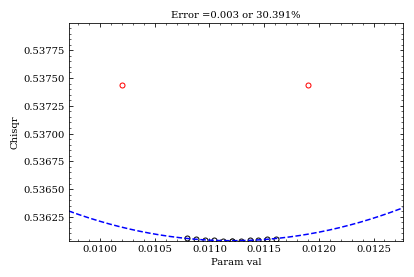

[=================================       ] 40/48 ( 83%)  8 to go

fit A131.73633323013388
fit B0.005132599662071691
fit C0.5360348149324508


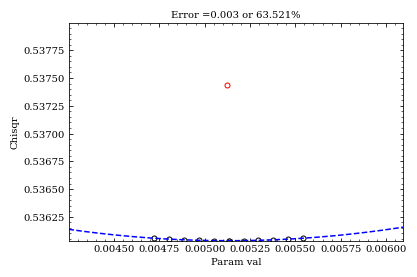

[==================================      ] 41/48 ( 85%)  7 to go

fit A126.74013281512856
fit B0.002443647284203543
fit C0.5360348098784279


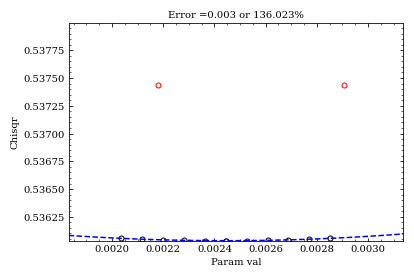

[===================================     ] 42/48 ( 87%)  6 to go

fit A750.3116583452238
fit B0.0
fit C0.536021570148306


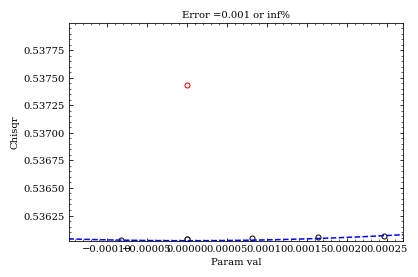

[===================================     ] 43/48 ( 89%)  5 to go

fit A121.23220786299873
fit B0.0025462367319681878
fit C0.5360348112307947


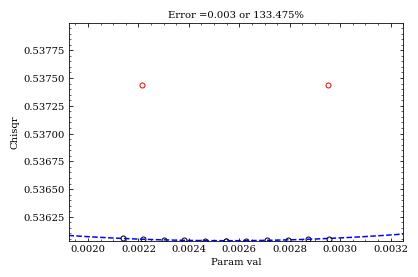

[====================================    ] 44/48 ( 91%)  4 to go

fit A1534.804054385985
fit B0.0
fit C0.536001967173732


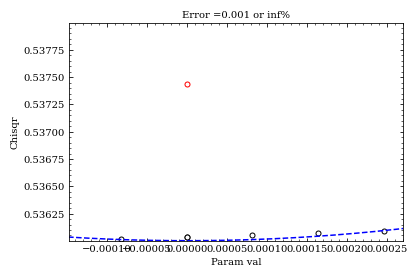

[=====================================   ] 45/48 ( 93%)  3 to go

fit A1893.8571596732895
fit B0.0
fit C0.5359938018610083


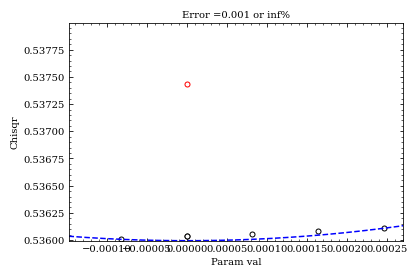

[======================================  ] 46/48 ( 95%)  2 to go

fit A53.06264614113595
fit B0.0040943219425508826
fit C0.5360348095391237


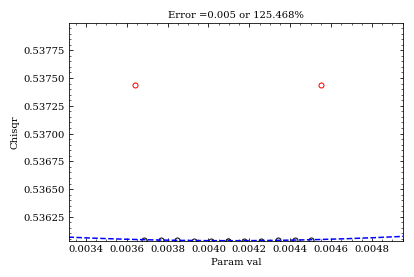

[======================================= ] 47/48 ( 97%)  1 to go

fit A33.342322494605924
fit B0.0024943725229122915
fit C0.5360348147387738


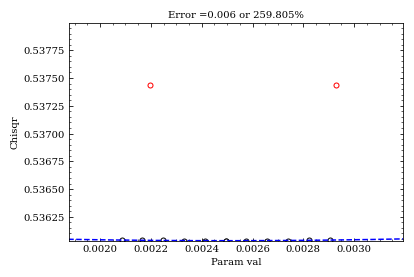

[========================================] 48/48 (100%)  0 to go

fit A0.0037593077294447164
fit B1.71557814867528
fit C0.4228744158028964


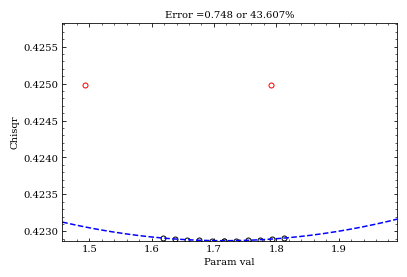

[=                                       ]  1/38 (  2%) 37 to go

fit A0.0061013352805820865
fit B1.811864094870631
fit C0.42287443032227434


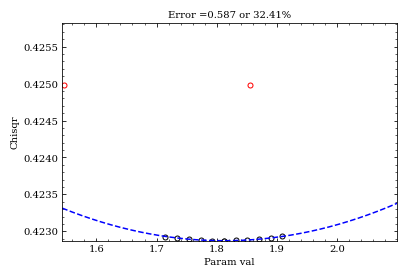

[==                                      ]  2/38 (  5%) 36 to go

fit A0.009178296331009972
fit B1.6767947545450652
fit C0.4228744123568653


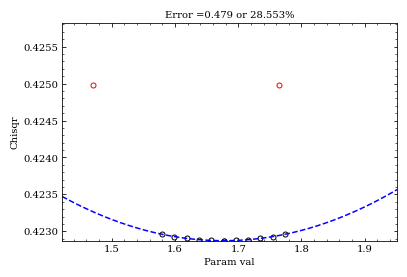

[===                                     ]  3/38 (  7%) 35 to go

fit A0.010333573304012859
fit B0.9876113856044015
fit C0.4228744099185712


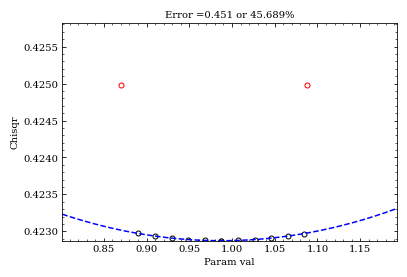

[====                                    ]  4/38 ( 10%) 34 to go

fit A0.011779779617159869
fit B1.646924883410669
fit C0.42287440994112113


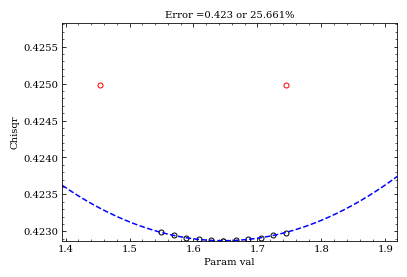

[=====                                   ]  5/38 ( 13%) 33 to go

fit A0.012650624260180087
fit B1.4943541879269835
fit C0.42287441660982916


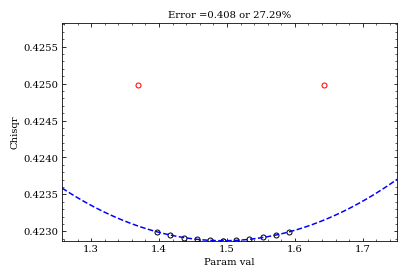

[======                                  ]  6/38 ( 15%) 32 to go

fit A0.011131565812437925
fit B2.67896742408272
fit C0.4228744158171237


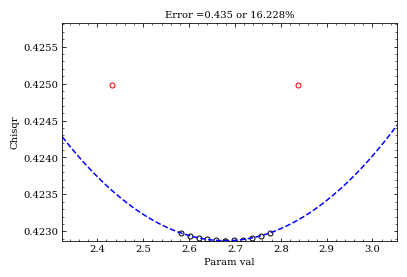

[=======                                 ]  7/38 ( 18%) 31 to go

fit A0.01296744560699373
fit B1.004969181695312
fit C0.42287440989669683


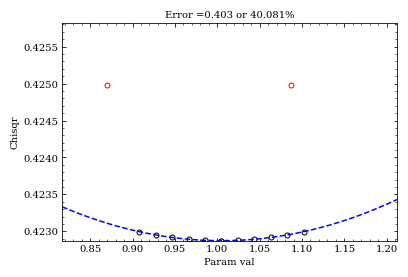

[========                                ]  8/38 ( 21%) 30 to go

fit A0.012656159045082166
fit B0.9678532933624414
fit C0.4228744114911071


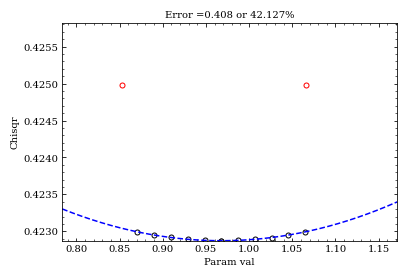

[=========                               ]  9/38 ( 23%) 29 to go

fit A0.012405296097334387
fit B1.4020149806866087
fit C0.4228744101876499


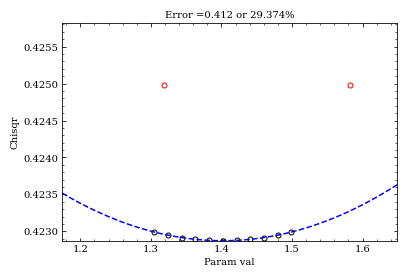

[==========                              ] 10/38 ( 26%) 28 to go

fit A0.011441425983240537
fit B0.9768625178596378
fit C0.4228744145209317


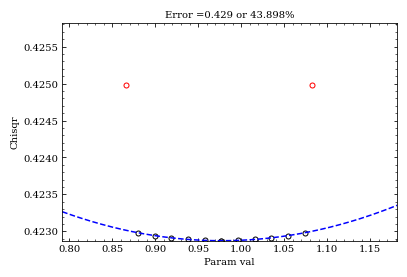

[===========                             ] 11/38 ( 28%) 27 to go

fit A0.011418360855738106
fit B1.5497217959674563
fit C0.4228744107719556


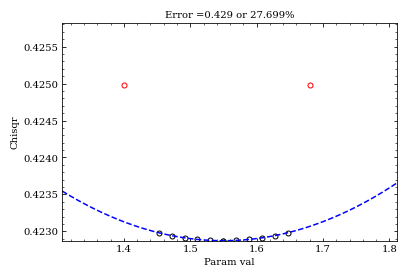

[============                            ] 12/38 ( 31%) 26 to go

fit A0.01242662083551902
fit B-0.5422809565409531
fit C0.4228744113289455


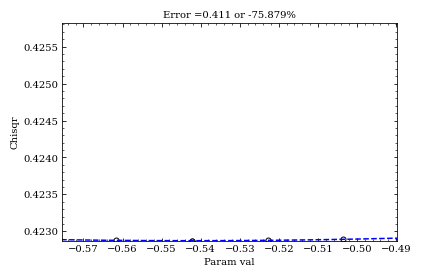

[=============                           ] 13/38 ( 34%) 25 to go

fit A0.012606467762357961
fit B1.4598842160637797
fit C0.42287441111796514


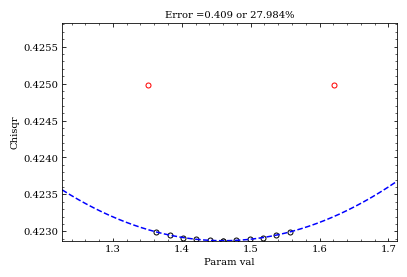

[==============                          ] 14/38 ( 36%) 24 to go

fit A0.014056940772957487
fit B1.2032897416910542
fit C0.422874417664728


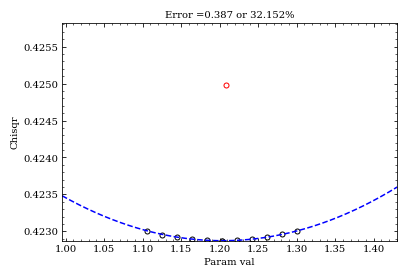

[===============                         ] 15/38 ( 39%) 23 to go

fit A0.014720903924787575
fit B0.7016286031665651
fit C0.4228744141609004


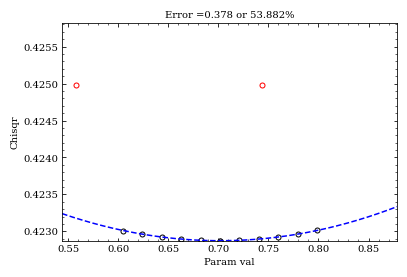

[================                        ] 16/38 ( 42%) 22 to go

fit A0.01574668965075037
fit B0.5712249857944612
fit C0.422874414448374


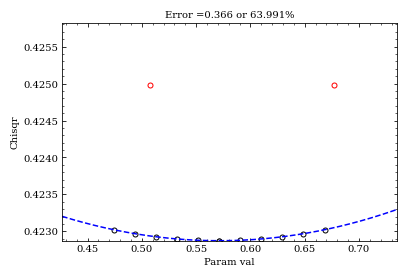

[=================                       ] 17/38 ( 44%) 21 to go

fit A0.014020705181370595
fit B0.17056619000718343
fit C0.42287441648370316


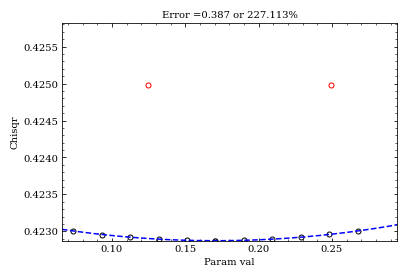

[==================                      ] 18/38 ( 47%) 20 to go

fit A0.012894507208304916
fit B1.0015922256275716
fit C0.4228744102801592


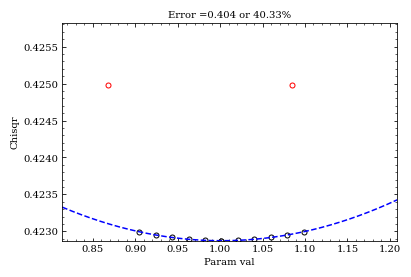

[====================                    ] 19/38 ( 50%) 19 to go

fit A0.02056358277773471
fit B0.7326770849592483
fit C0.4228744192996818


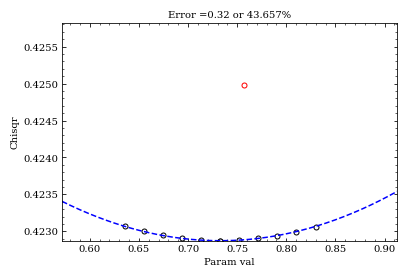

[=====================                   ] 20/38 ( 52%) 18 to go

fit A0.012586527931588319
fit B0.3996705563468101
fit C0.42287442549213616


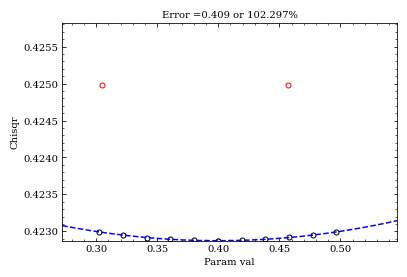

[======================                  ] 21/38 ( 55%) 17 to go

fit A0.012574660498474773
fit B1.3719935411668183
fit C0.42287442384080803


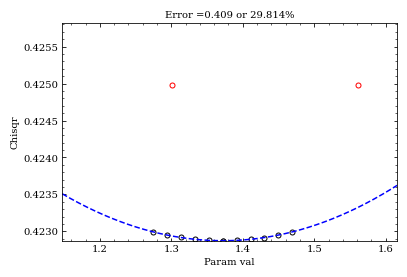

[=======================                 ] 22/38 ( 57%) 16 to go

fit A0.013400261167815328
fit B0.6309430934774223
fit C0.42287441408416987


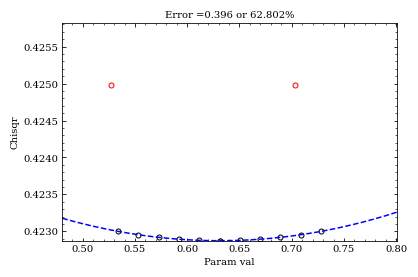

[========================                ] 23/38 ( 60%) 15 to go

fit A0.01471021522970687
fit B0.8623666982806154
fit C0.42287441208114196


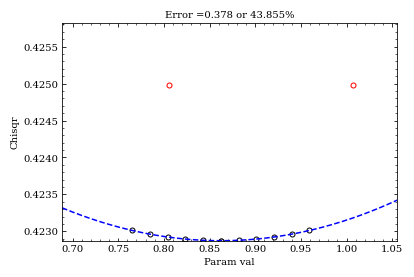

[=========================               ] 24/38 ( 63%) 14 to go

fit A0.012417883655705767
fit B0.6540755241092496
fit C0.42287440989512753


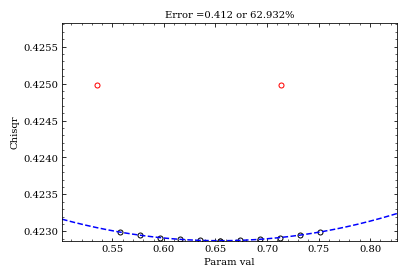

[==========================              ] 25/38 ( 65%) 13 to go

fit A0.011920220988482078
fit B0.46255342649073167
fit C0.4228744156546751


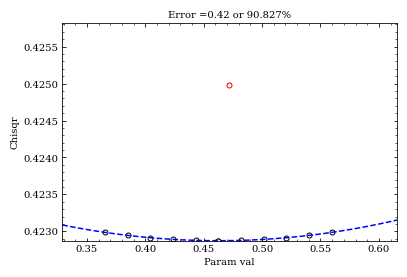

[===========================             ] 26/38 ( 68%) 12 to go

fit A0.009390931799721908
fit B0.42321519598637525
fit C0.422874416389199


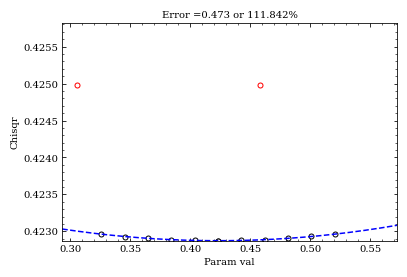

[============================            ] 27/38 ( 71%) 11 to go

fit A0.009138711247832814
fit B0.8027646583370117
fit C0.4228744114931755


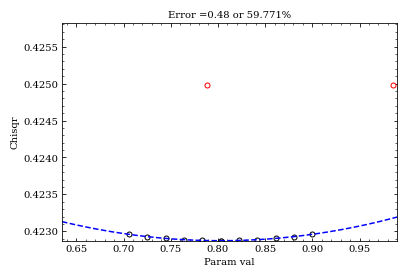

[=============================           ] 28/38 ( 73%) 10 to go

fit A0.005374092105774523
fit B1.1437372888499078
fit C0.4228744099244391


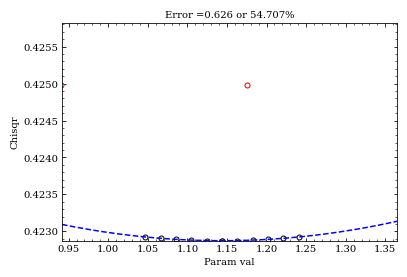

[==============================          ] 29/38 ( 76%)  9 to go

fit A0.005524901031017957
fit B0.61178866332632
fit C0.42287440995665987


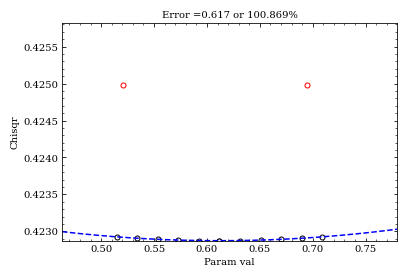

[===============================         ] 30/38 ( 78%)  8 to go

fit A0.02249553457879874
fit B0.08951023040336632
fit C0.42287441647479596


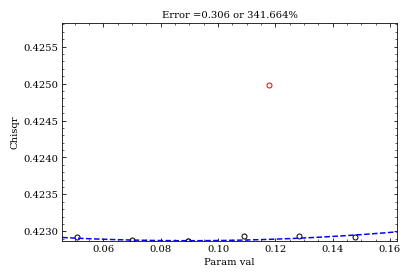

[================================        ] 31/38 ( 81%)  7 to go

fit A15.343984076245329
fit B0.035241406693450994
fit C0.42287441232173023


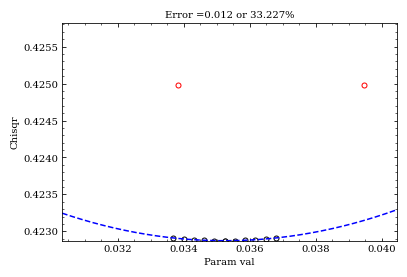

[=================================       ] 32/38 ( 84%)  6 to go

fit A17.07093802939088
fit B0.04389476998847197
fit C0.42287440991095954


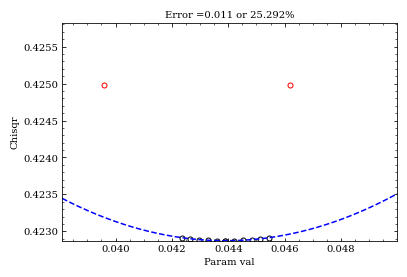

[==================================      ] 33/38 ( 86%)  5 to go

fit A17.9326265163393
fit B0.045415635430970935
fit C0.4228744186276809


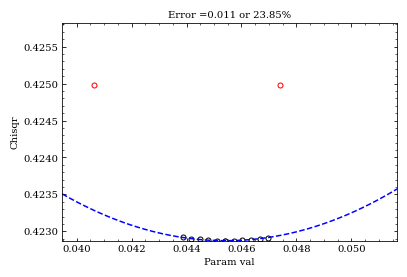

[===================================     ] 34/38 ( 89%)  4 to go

fit A12.69895048331792
fit B0.06173245988278264
fit C0.42287441221212785


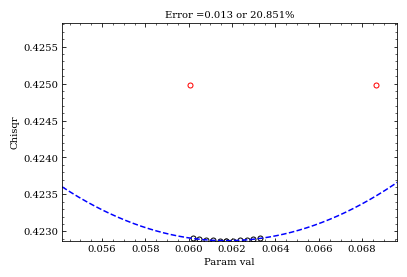

[====================================    ] 35/38 ( 92%)  3 to go

fit A17.104967335634026
fit B0.05690229339742192
fit C0.42287440991363473


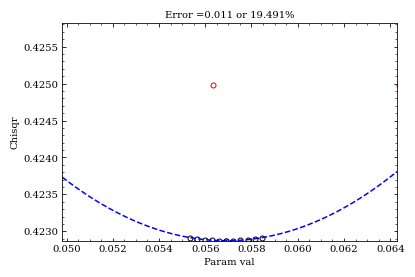

[=====================================   ] 36/38 ( 94%)  2 to go

fit A17.125824462825737
fit B0.035149211705431505
fit C0.4228744100341752


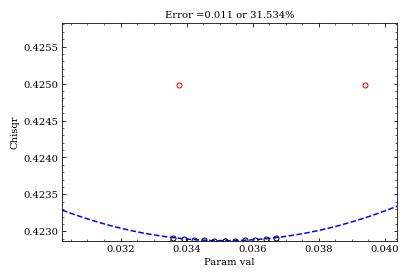

[======================================  ] 37/38 ( 97%)  1 to go

fit A22.98528997667812
fit B0.04565439551294492
fit C0.4228744107765874


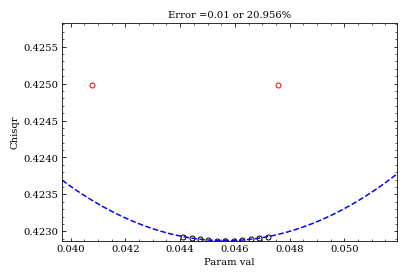

[========================================] 38/38 (100%)  0 to go

In [7]:
macs5_factor_fname='MACS5_fact.npy'
macs5factor=MDfactorization(mtd['macs_5mag'],mag_ion='Ir4',\
                                     q_lim=[0.5,2],e_lim=[1.0,10],Ei=13.7,\
                                     twoThetaMin=False,plot_result=False,method='powell',fname=macs5_factor_fname,\
                                     overwrite_prev=True,allow_neg_E=False,g_factor=2.0,fast_mode=False)
macs3_factor_fname='MACS3p7_fact.npy'
macs3factor=MDfactorization(mtd['macs_3p7mag'],mag_ion='Ir4',\
                                     q_lim=[0.5,2],e_lim=[0.5,1.3],Ei=5.0,\
                                     twoThetaMin=False,plot_result=False,method='powell',fname=macs3_factor_fname,\
                                     overwrite_prev=True,allow_neg_E=False,g_factor=2.0,fast_mode=False)



Moment = 1.732 (0.130)


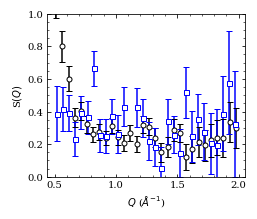

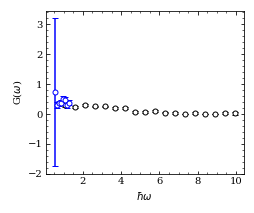

In [8]:
#Quick plots checking the factorizations, recalling that the spectral weight integrates to one
scale3=0.3

fig,ax=plt.subplots(1,1,figsize=(3.54,3))
ax.errorbar(macs5factor[0],macs5factor[1],macs5factor[2],color='k',marker='o',ls=' ',capsize=3)
ax.errorbar(macs3factor[0],macs3factor[1]/scale3,macs3factor[2]/scale3,color='b',marker='s',ls=' ',capsize=3)
ax.set_xlabel('$Q$ ($\AA^{-1}$)')
ax.set_ylabel('S$(Q)$')
ax.set_ylim(0,1)

fig,ax=plt.subplots(1,1,figsize=(3.54,3))
ax.errorbar(macs5factor[3],macs5factor[4],macs5factor[5],color='k',marker='o',ls=' ',capsize=3)
ax.errorbar(macs3factor[3],macs3factor[4]*scale3,macs3factor[5]*scale3,color='b',marker='o',ls=' ',capsize=3)
ax.set_ylabel('G($\omega$)')
ax.set_xlabel('$\hbar\omega$')

#Overall moment suggested by this factorization:
norm_err = 0.3# as a percent error
frac_err = norm_err#*macs5factor[1]/macs5factor[2]
momentsqr = 3.0*(2.0**2)*np.trapz(macs5factor[1]*macs5factor[0]**2,x=macs5factor[0])/\
            np.trapz(macs5factor[0]**2,x=macs5factor[0])
moment = np.sqrt(momentsqr)

errnum = get_trapz_err(macs5factor[0],macs5factor[1]*macs5factor[0]**2,\
                       macs5factor[1]*np.sqrt((macs5factor[2]/macs5factor[1])**2+frac_err**2)\
                       *macs5factor[0]**2)
momentsqr_err = 3.0*(2.0**2) * errnum/np.trapz(macs5factor[0]**2,x=macs5factor[0])
moment_err = (moment*momentsqr_err/momentsqr)/2.0
print(f"Moment = {moment:.3f} ({moment_err:.3f})")

## Plot of HYS measurements here

Int G(omega)=1.4799280042456


constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.
constrained_layout not applied.  At least one axes collapsed to zero width or height.


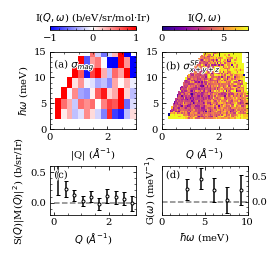

In [42]:
fig=plt.figure(constrained_layout=True,figsize=(3.54,3.0))

gs = matplotlib.gridspec.GridSpec(12,2,figure=fig,hspace=1.5,wspace=0.3)

ax_mag_sqe = fig.add_subplot(gs[0:6,0],projection='mantid')
ax_sf_sqe = fig.add_subplot(gs[0:6,1],projection='mantid')

ax_sq = fig.add_subplot(gs[8:,0])
ax_ge = fig.add_subplot(gs[8:,1])

#Add low energy masking
ws_hys_masked= mask_QE_box_MD(mtd['hys_mag'],[0,5],[0,2])
ws_hys_masked = CloneWorkspace(ws_hys_masked,OutputWorkspace='hys_mag_plot')
ws_hys_maskedSF= mask_QE_box_MD(mtd['hys_SF'],[0,5],[0,2])
ws_hys_maskedSF = CloneWorkspace(ws_hys_maskedSF,OutputWorkspace='hys_SF_plot')

mesh_mag = ax_mag_sqe.pcolormesh(mtd['hys_mag_plot'],vmin=-1,vmax=1,cmap='bwr',rasterized=True)
ax_mag_sqe.set_xlim(0,3)
ax_mag_sqe.set_ylim(0,15)
txta=ax_sf_sqe.text(0.05,0.92,'(a) $\sigma_{mag}$',transform=ax_mag_sqe.transAxes,horizontalalignment='left',verticalalignment='top')
txta.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])
#Add a colorbar to magnetic 
l,b,w,h=ax_mag_sqe.get_position().bounds
cax = fig.add_axes([l,b+h+0.1,w,0.02])
labelstr='I($Q,\omega$) (b/eV/sr/mol$\cdot$Ir)'
cbar = plt.colorbar(mesh_mag,orientation='horizontal',cax=cax)
cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',verticalalignment='bottom')
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))

ax_mag_sqe.set_ylabel('$\hbar\omega$ (meV)')

mesh_sf = ax_sf_sqe.pcolormesh(mtd['hys_SF_plot'],vmin=0,vmax=7,cmap=cmap,rasterized=True)
ax_sf_sqe.set_ylabel('')
ax_sf_sqe.set_xlim(0,3)
ax_sf_sqe.set_ylim(0,15)
txtb=ax_sf_sqe.text(0.05,0.92,'(b) $\sigma_{x+y+z}^{SF}$',transform=ax_sf_sqe.transAxes,horizontalalignment='left',verticalalignment='top')
txtb.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

#Add a colorbar for SF
l,b,w,h=ax_sf_sqe.get_position().bounds
cax = fig.add_axes([l,b+h+0.1,w,0.02])
labelstr='I($Q,\omega$)'
cbar = plt.colorbar(mesh_sf,orientation='horizontal',cax=cax)
cax.text(0.5,1.5,labelstr,transform=cax.transAxes,horizontalalignment='center',verticalalignment='bottom')
cax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))


#Cuts in Q, energy, are done on the analysis cluster - event files too large for personal machine. 
# Scripts for cluster available upon request.
# Original scaling was 1.0e5
# New normalization is 2.0e5, adjust
rescale = 2.0e5/1.0e5
qcutmag = np.genfromtxt('../Part 5 - HYS Scattering/cut_data/sq_mag_cut_.txt',skip_header=2)
ecutmag = np.genfromtxt('../Part 5 - HYS Scattering/cut_data/ge_mag_cut.txt',skip_header=2)
qcutmag[:,0]*=rescale
qcutmag[:,1]*=rescale
ecutmag[:,0]*=rescale
ecutmag[:,1]*=rescale
r0=0.5391
g=2.0
xtos = 2.0*(r0**2 * g**2)
#For some reason MANTID 
ax_sq.errorbar(qcutmag[:,2],qcutmag[:,0]/xtos,qcutmag[:,1]/xtos,color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=2,ms=3)

ax_ge.errorbar(ecutmag[:,2],ecutmag[:,0],ecutmag[:,1],color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=2,ms=3)
ax_ge.set_xlim(0,10)
ax_sq.set_ylim(-0.2,0.6)
ax_sq.plot(np.linspace(0,np.nanmax(qcutmag[:,2]),1000),np.zeros(1000),'k--',alpha=0.5)
ax_ge.plot(np.linspace(0,10,1000),np.zeros(1000),'k--',alpha=0.5)
ax_ge.yaxis.tick_right()

ax_sq.set_xlabel('$Q$ ($\AA^{-1}$)')
ax_sf_sqe.set_xlabel('$Q$ ($\AA^{-1}$)')

ax_ge.set_xlabel('$\hbar\omega$ (meV)')

ax_sq.set_ylabel('S($Q$)|M($Q$)|$^2$) (b/sr/Ir)')
ax_ge.set_ylabel('G($\omega$) (meV$^{-1}$)')


txtc=ax_sq.text(0.05,0.9,'(c)',transform=ax_sq.transAxes,horizontalalignment='left',verticalalignment='top')
txtc.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

txtd=ax_ge.text(0.05,0.9,'(d)',transform=ax_ge.transAxes,horizontalalignment='left',verticalalignment='top')
txtd.set_path_effects([PathEffects.withStroke(linewidth=2,foreground='w')])

integral = np.trapz(ecutmag[:,0],x=ecutmag[:,2])
print(f"Int G(omega)={integral}")

fig.savefig('HYS_scattering.pdf',bbox_inches='tight',dpi=300)

## HYS factorizations, or attempts. 

This is extremely touchy due to poor statistics.

In [43]:
hys_mag_factorname='hys_magfactor.npy'

md_factor = mtd['hys_mag']
factor_hysmag = MDfactorization(md_factor,mag_ion='Ir4', q_lim=[0.2,2.0],e_lim=[2.0,10.0],Ei=20.0,
                                     twoThetaMin=False,plot_result=True,method='powell',fname=hys_mag_factorname,
                                     overwrite_prev=True,g_factor=2.0,fast_mode=True,allow_neg_E=False)

#Instead it is easier to just use the cuts with the appropriate normalizations. Fitting routine is not stable.
factor_hysmag_alt = [qcutmag[:,2]*integral,qcutmag[:,0]*integral,qcutmag[:,1]*integral,\
                     ecutmag[:,2]/integral,ecutmag[:,0]/integral,ecutmag[:,1]/integral]
#Mask highQ vals

<ErrorbarContainer object of 3 artists>

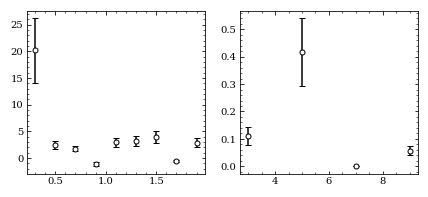

In [44]:
#For transparency, show the factorization as well.
fig, ax = plt.subplots(1,2,figsize=(7,3))
ax[0].errorbar(factor_hysmag[0],factor_hysmag[1],factor_hysmag[2],color='k')
ax[1].errorbar(factor_hysmag[3],factor_hysmag[4],factor_hysmag[5],color='k')
#ax[0].set_ylim(-0.1,0.5)
#ax[1].set_ylim(0,1)

Moment from cut= 1.676 (0.660)
Moment from factorization= 4.818 (nan)


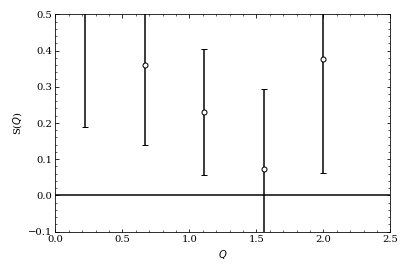

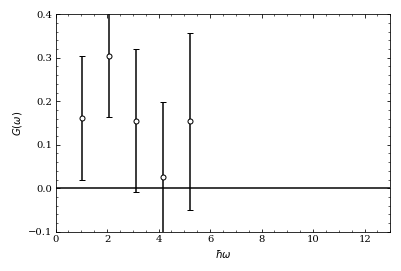

In [45]:
plt.figure()
#plt.errorbar(factor_hysmag[0],factor_hysmag[1],factor_hysmag[2])
qff,ff = get_MANTID_magFF(factor_hysmag_alt[0],mag_ion='Ir4')
magffsqr=1.0/ff
r0=0.5391
g=2.0
sq_alt = factor_hysmag_alt[1]*1.0/(2.0 * r0**2 * g**2 * magffsqr)
sq_alt_err = factor_hysmag_alt[2]*1.0/(2.0 *r0**2 * g**2 * magffsqr)
#Mask high Q values
maxQ = 2.0
sq_alt=sq_alt[np.where(factor_hysmag_alt[0]<maxQ)[0]]
sq_alt_err=sq_alt_err[np.where(factor_hysmag_alt[0]<maxQ)[0]]
q_alt = factor_hysmag_alt[0][np.where(factor_hysmag_alt[0]<maxQ)[0]]

plt.errorbar(q_alt,sq_alt,sq_alt_err,marker='o',ls=' ',color='k')

plt.plot(np.linspace(0,3,1000),np.zeros(1000),'k-')
plt.ylim(-0.1,0.5)
plt.xlim(0,2.5)
plt.xlabel('$Q$')
plt.ylabel('S($Q$)')
plt.figure()
#plt.errorbar(factor_hysmag[3],factor_hysmag[4],factor_hysmag[5])
plt.errorbar(factor_hysmag_alt[3]-1,factor_hysmag_alt[4],factor_hysmag_alt[5],marker='o',ls=' ',color='k')
plt.plot(np.linspace(0,15,1000),np.zeros(1000),'k-')
plt.xlim(0,13)
plt.ylim(-0.1,0.4)
plt.xlabel('$\hbar\omega$')
plt.ylabel('$G(\omega)$')

#Overall moment suggested by this factorization:
norm_err = 0.3
frac_err = norm_err#*factor_hysmag_alt[2]/factor_hysmag_alt[1]
moment_frac = 1.0
momentsqr = 3.0*(g**2)*np.trapz(moment_frac*sq_alt*q_alt**2,x=q_alt)/\
            np.trapz(q_alt**2,x=q_alt)
moment = np.sqrt(momentsqr)
errnum = get_trapz_err(q_alt,sq_alt*q_alt**2,\
                       sq_alt*np.sqrt((sq_alt/sq_alt_err)**2 + frac_err**2)*q_alt**2)
momentsqr_err = 3.0*(g**2) * errnum/np.trapz(q_alt**2,x=q_alt)
moment_err = (moment*momentsqr_err/momentsqr)/2.0
print(f"Moment from cut= {moment:.3f} ({moment_err:.3f})")
momentsqr = 3.0*(g**2)*np.trapz(moment_frac*factor_hysmag[1]*factor_hysmag[0]**2,x=factor_hysmag[0])/\
            np.trapz(factor_hysmag[0]**2,x=factor_hysmag[0])
moment = np.sqrt(momentsqr)
errnum = get_trapz_err(factor_hysmag[0],factor_hysmag[1]*factor_hysmag[0]**2,\
                       factor_hysmag[1]*np.sqrt((factor_hysmag[1]/factor_hysmag[2])**2 + frac_err**2)*factor_hysmag[0]**2)
momentsqr_err = 3.0*(g**2) * errnum/np.trapz(factor_hysmag[0]**2,x=factor_hysmag[0])
moment_err = (moment*momentsqr_err/momentsqr)/2.0
print(f"Moment from factorization= {moment:.3f} ({moment_err:.3f})")


## Finally, figure with factorizations + THz

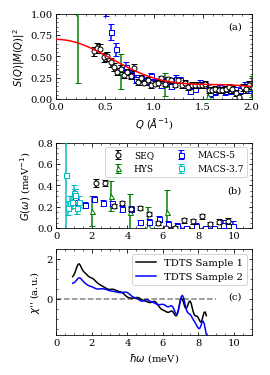

In [49]:
#THz imports 
thz_dir = "THz/"
thz_trans_main = np.genfromtxt(thz_dir+'Final_transmission_main_pellet.txt',skip_header=1)
temps_thz_trans_main = np.array([3.0,5.0,8.0,10.0,12.0,14.0,16.0,18.0,20.0,22.0,25.0,30.0,\
                                 40.0,50.0,70.0,100.0,125.0,300.0])
thz_trans2_main = np.genfromtxt(thz_dir+'Final_transmission_main_pellet_2.txt',skip_header=1)
temps_thz_trans2_main = np.array([3.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,50.0,70.0,100.0,125.0,150.0,175.0,\
                                 200.0,225.0,250.0,275.0,296.0])
thz_chi2_1 = np.genfromtxt(thz_dir+'Magnetic-susceptibility.txt',skip_header=1)
temps_thz_chi2_1 = np.array([14.0,12.0,10.0,10.0,8.0,5.0,3.0,14.0,12.0,10.0,10.0,8.0,5.0,3.0]) #Chi2 then chi2
thz_chi2_2 = np.genfromtxt(thz_dir+'Magnetic-susceptibility_2_ref25K.txt',skip_header=1)
temps_thz_chi2_2 = np.array([3.0,10.0,15.0,20.0,25.0,3.0,10.0,15.0,20.0,25.0]) #Chi1 then Chi2
thz_T_tempcut = np.genfromtxt(thz_dir +'transmission-temp-cuts_1.txt',skip_header=1)
freqs_thz_Ttempcut = np.array([0.41,0.45,0.50,0.55,0.60,0.70,0.75,0.80,0.85,0.90,\
                               0.41,0.45,0.50,0.55,0.60,0.70,0.75,0.80,0.85,0.90]) #Transmission frequency, then error
thz_T2_tempcut = np.genfromtxt(thz_dir +'transmission-temp-cuts_2.txt',skip_header=1)
freqs_thz_T2tempcut = np.array([0.35,0.41,0.45,0.55,0.60,0.70,0.75,0.80,0.85,0.90,\
                               0.35,0.41,0.45,0.55,0.60,0.70,0.75,0.80,0.85,0.90])
thz_T3_tempcut = np.genfromtxt(thz_dir+'transmission-temp-cuts_1_more_temp.txt',skip_header=1)
freqs_thz_T3tempcut = np.array([0.43,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85])

#First plot the THz spectra in the upper figure
THz_to_meV = 4.18
THz_3K_sample1 = thz_chi2_1[:,6]*1e3
THz_3K_E_sample1 = thz_chi2_1[:,0]*THz_to_meV
THz_3K_sample2 = thz_chi2_1[:,3]*1e3
THz_3K_E_sample2 = thz_chi2_1[:,0]*THz_to_meV

fig=plt.figure(constrained_layout=True,figsize=(3.54,5.0))

gs = matplotlib.gridspec.GridSpec(3,1,figure=fig,hspace=1.0,wspace=0.3)

sq_ax = fig.add_subplot(gs[0])
gw_ax = fig.add_subplot(gs[1])
thz_ax = fig.add_subplot(gs[2])

#Start with S(Q) factorizations, fit to model
# We want to plot the more closely observed quantity |F(Q)|^2 * S(Q)
# SEQ, MACS, HYS
seq_scale = 1.0
sq_ax.text(0.95,0.9,'(a)',transform=sq_ax.transAxes,horizontalalignment='right',\
           verticalalignment='top')
markersize=5
macs3scale=1.0/0.2
macs5scale=1.0/0.94

ffseq = 1.0/get_MANTID_magFF(qseq,'Ir4')[1]
sq_ax.errorbar(qseq,sqseq*seq_scale*ffseq,ffseq*sqerrseq*seq_scale,color='k',\
               marker='o',mfc='w',mec='k',ls=' ',capsize=3,zorder=10,ms=markersize)
ffmacs = 1.0/get_MANTID_magFF(macs5factor[0],'Ir4')[1]
sq_ax.errorbar(macs5factor[0],macs5factor[1]*ffmacs*macs5scale,macs5factor[2]*ffmacs*macs5scale,color='b',\
               marker='s',ls=' ',capsize=3,zorder=5,mfc='w',ms=markersize)
ffhys = 1.0/get_MANTID_magFF(q_alt,'Ir4')[1]
sq_ax.errorbar(q_alt,sq_alt*ffhys,sq_alt_err*ffhys,color='g',\
               marker='^',ls=' ',capsize=3,zorder=5,mfc='w',ms=markersize)
def modelq(q,A):
    return A*(1.0+np.sin(q*3.54)/(q*3.54))
qmodel = np.linspace(0,2.5,1000)
ffmodel=1.0/get_MANTID_magFF(qmodel,'Ir4')[1]
sq_ax.plot(qmodel,modelq(qmodel,0.35)*seq_scale*ffmodel,'r-',zorder=100)
#Now G(omega)

#Strange error bars on the lowest energy seq and MACS 3.7 meV data.
geerrseq[0] = np.nanmean(geerrseq[1:])*2.0
macs3factor[4][0] = np.nanmean(macs3factor[4][1:])*2.0
gw_ax.errorbar(eseq,geseq/seq_scale,geerrseq/seq_scale,color='k',marker='o',mfc='w',mec='k',ls=' ',\
               capsize=3,zorder=10,label='SEQ',ms=markersize)
gw_ax.errorbar(factor_hysmag_alt[3],factor_hysmag_alt[4],factor_hysmag_alt[5],color='g',\
               marker='^',ls=' ',capsize=3,zorder=5,mfc='w',label='HYS',ms=markersize)
gw_ax.errorbar(macs5factor[3],macs5factor[4]/macs5scale,macs5factor[5]/macs5scale,color='b',\
               marker='s',ls=' ',capsize=3,zorder=5,mfc='w',label='MACS-5',ms=markersize)
gw_ax.errorbar(macs3factor[3],macs3factor[4]/macs3scale,macs3factor[5]/macs3scale,color='c',\
               marker='s',ls=' ',capsize=3,zorder=5,mfc='w',label='MACS-3.7',ms=markersize)

gw_ax.text(0.95,0.5,'(b)',transform=gw_ax.transAxes,horizontalalignment='right',\
           verticalalignment='top')
gw_ax.legend(fontsize=9,loc=1,ncol=2)
gw_ax.set_ylim(0,0.8)

sq_ax.set_ylim(0,1)
sq_ax.set_xlim(0,2.0)


thz_ax.plot(THz_3K_E_sample1,THz_3K_sample1,'k-',label='TDTS Sample 1')
thz_ax.plot(THz_3K_E_sample2,THz_3K_sample2,'b-',label='TDTS Sample 2')
thz_ax.plot(np.linspace(0,9,1000),np.zeros(1000),'k--',alpha=0.5)
thz_ax.set_ylabel('$\chi$\'\' (a.u.)')
thz_ax.text(0.95,0.5,'(c)',transform=thz_ax.transAxes,horizontalalignment='right',\
           verticalalignment='top')

#Have the G(w) and THz subplots share an x-axis 
thz_ax.sharex(gw_ax)
thz_ax.set_ylim(-1.8,2.5)
thz_ax.set_xlim(0,11)
thz_ax.legend()

#Axis labels
sq_ax.set_ylabel('$S(Q)|M(Q)|^2$')
sq_ax.set_xlabel(r'$Q$ $(\AA^{-1}$)')

gw_ax.set_ylabel('$G(\omega)$ (meV$^{-1}$)');
thz_ax.set_xlabel('$\hbar\omega$ (meV)')

fig.savefig('HLIO_factorizations_THz.pdf',bbox_inches='tight')

Integrated g(w)=1.00


(-0.05, 0.5)

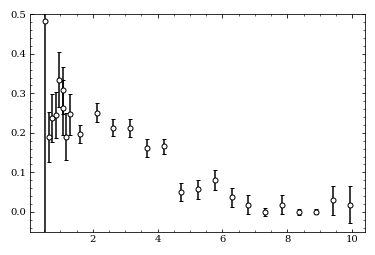

In [14]:
# The MACS data is assumed to cover the full spectral range, thus its G(omega) should integrate to one. 
frac3 = 0.2
frac5 = 0.85
e_all_macs = np.append(macs3factor[3],macs5factor[3])
ge_all_macs = np.append(macs3factor[4]*frac3,frac5*macs5factor[4])
geerr_all_macs = np.append(macs3factor[5]*frac3,macs5factor[5]*frac5)
#Sort these
sorti = np.argsort(e_all_macs)
e_all_macs, ge_all_macs, geerr_all_macs = e_all_macs[sorti], ge_all_macs[sorti], geerr_all_macs[sorti]

integral = np.trapz(ge_all_macs,x=e_all_macs)
print(f"Integrated g(w)={integral:.2f}")
fig,ax = plt.subplots(1,1)
ax.errorbar(e_all_macs,ge_all_macs,geerr_all_macs,color='k',marker='o',mfc='w',mec='k',ls=' ',capsize=2)
ax.set_ylim(-0.05,0.5)

[[Model]]
    Model(knolle_qmodel)
[[Fit Statistics]]
    # fitting method   = Powell
    # function evals   = 224
    # data points      = 47
    # variables        = 2
    chi-square         = 202.205769
    reduced chi-square = 4.49346154
    Akaike info crit   = 72.5794971
    Bayesian info crit = 76.2797924
[[Variables]]
    A:  0.30320785 (init = 0.3)
    K: -0.01552797 (init = -10)



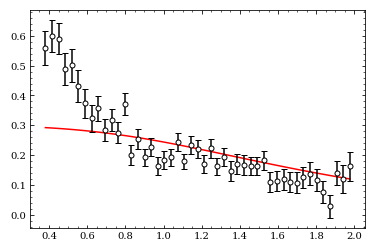

In [15]:
## Fit to find the rough value of $K$
#qseq,sqseq*seq_scale*ffseq,ffseq*sqerrseq*seq_scale

def knolle_qmodel(q,A,K):
    return A*(1+K*np.cos(q*3.54))

modelK = Model(knolle_qmodel)
paramsK = modelK.make_params()
paramsK.add('A',value=0.3,min=0.0,max=100.0)
paramsK.add('K',value=-10,min=-200,max=200)
resultK = modelK.fit(sqseq,q=qseq,weights=1.0/sqerrseq,params=paramsK,method='powell')
fig,ax = plt.subplots(1,1)
ax.errorbar(qseq,sqseq*seq_scale*ffseq,ffseq*sqerrseq*seq_scale,color='k',\
               marker='o',mfc='w',mec='k',ls=' ',capsize=3,zorder=10,ms=markersize)
ax.plot(qseq,resultK.best_fit*ffseq*seq_scale,'r-')
print(resultK.fit_report())